# Convert molecular properties into NASA polynomials for use in RMG and Cantera

Notebook from Dr. Bjarne Kreitz, Dr. Katrín Blöndal, and Prof. C. Franklin Goldsmith at Brown University

In [1]:
import numpy as np
import scipy
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import NullFormatter, MaxNLocator, LogLocator
%matplotlib inline

# declare a class for molecules
class Molecule:
    
        def __init__(self):
                #start by defining some physical constants
                self.R = 8.3144621E-3 #ideal Gas constant in kJ/mol-K
                self.kB = 1.38065e-23 #Boltzmann constant in J/K
                self.h = 6.62607e-34 #Planck constant in J*s
                self.c = 2.99792458e8 #speed of light in m/s
                self.amu = 1.6605e-27 #atomic mass unit in kg
                self.Avogadro = 6.0221E23 #mole^-1
                self.GHz_to_Hz = 1.0E9 #convert rotational constants from GHz to Hz
                self.invcm_to_invm = 1.0E2 #convert cm^-1 to m^-1, for frequencies
                self.P_ref = 1.0E5 #reference pressure, 1 bar = 1E5 Pascal
                self.hartree_to_kcalpermole = 627.5095 #convert hartree/molecule to kcal/mol
                self.hartree_to_kJpermole = 2627.25677 #convert hartree/molecule to kJ/mol
                self.eV_to_kJpermole = 96.485 #convert eV/molecule to kJ/mol
                self.T_switch = 1000.0 #K, switching temperature in NASA polynomial. Default. can overwrite.
                self.site_occupation_number = 1 #number of sites occupied by adsorbate
                self.unit_cell_area = 62.105e-20/9.0 #m2 - using surface area per binding site (nine binding sites per cell)
                self.cutoff_frequency = 100.0 #cm^-1
                self.twoD_gas = False
                self.eV_to_kJpermole = 96.485 #convert eV/molecule to kJ/mol
                self.dHfatct={'CH4':-66.557,'H2O':-238.929,'H2':0,'NH3':-38.565}#heats of formation (0K) in kJ/mol from the ATcT database for the reference species, version 1.122r (5/13/2022)
                self.Eref={'CH4':-324.294,'H2O':-611.0186083,'H2':-32.6984442,'NH3':-442.6510481} #DFT energies of the reference species (ZPE corrected) in eV
                self.Eslab=-377616.072 #DFT energy of the slab in eV
                self.dHrxnatct={'H2-2H':432.068, 'O2-2O':493.688, 'N2-2N':941.157} #Heats of the dissociation reactions in the gas phase from the ATcT database, version 1.122r (5/13/2022)
                self.molecular_mass_elements={'H': 1.007940, 'C': 12.01070, 'N': 14.006740, 'O': 15.99940}
                
# create the array of temperatures in 10 degree increments
temperature = [298.15] #NOTE 298.15 must be first for the NASA polynomial routine to work!
T_low = 300.0
T_high = 2000.0
dT = 10.0 #temperature increment
temperature = np.append(temperature, np.arange(T_low, T_high+dT, dT) )                

In [2]:
# HERE BEGINS THE LONG LIST OF SUBROUTINES
#-------------------------------------------------------------------------
# subroutine for the translational mode
def get_translation_thermo(molecule,temperature):
    # unpack the constants (not essential, but makes it easier to read)
    R = molecule.R
    kB = molecule.kB
    h = molecule.h
    amu = molecule.amu
    P_ref = molecule.P_ref
    m = float(molecule.molecule_mass)
    pi = np.pi

    #initialize the arrays for the partition function, entropy, enthalpy,
    #and heat capacity.
    Q_trans  = np.ones(len(temperature)) 
    S_trans  = np.zeros(len(temperature))
    dH_trans  = np.zeros(len(temperature))
    Cp_trans  = np.zeros(len(temperature))

    # cycle through each temperature
    for (i,T) in enumerate(temperature):
        # start with the volume. V = RT/P, assume P_ref = 1 bar
        V = kB*T/P_ref
        # partition function is: (2*pi*mass*kB*T/h**2)^(3/2) * V
        Q_trans[i] = (2*pi*m*amu*kB*T/h**2)**(1.5) * V
        S_trans[i] = R * (2.5 + np.log( Q_trans[i] )) #
        Cp_trans[i] = R * 2.5 #why 2.5? b/c Cv is 3/2, and Cp = Cv + R. We only do this once, for translation
        dH_trans[i] = R * 2.5 * T 

    # add the results to the thermo object
    molecule.Q_trans = Q_trans
    molecule.S_trans = S_trans
    molecule.dH_trans = dH_trans
    molecule.Cp_trans = Cp_trans

    return

#------------------------------------------------
# subroutine for the rotational mode
def get_rotational_thermo(molecule,temperature):
    R = molecule.R
    pi = np.pi
    
    #initialize the arrays for the partition function, entropy, enthalpy,
    #and heat capacity.
    Q_rot  = np.ones(len(temperature))
    S_rot  = np.zeros(len(temperature))
    dH_rot  = np.zeros(len(temperature))
    Cp_rot  = np.zeros(len(temperature))
    
    # cycle through each temperature
    if molecule.atom==False:
        for (i,T) in enumerate(temperature):
            if molecule.linear==True:
                Q_rot[i] = T / molecule.rotational_temperatures[0] / float(molecule.external_symmetry)
                S_rot[i] = R * ( np.log( Q_rot[i] ) + 1.0 )
                Cp_rot[i] = R * 1.0
                dH_rot[i] = R * 1.0 * T
            else:
                Q_rot[i] = pi**0.5 / float(molecule.external_symmetry)
                for value in molecule.rotational_temperatures:
                    Q_rot[i] *= (T/value)**0.5
                S_rot[i] = R * ( np.log( Q_rot[i] ) + 1.5 )
                Cp_rot[i] = R * 1.5
                dH_rot[i] = R * 1.5 * T
    
    # add the results to the thermo object
    molecule.Q_rot = Q_rot
    molecule.S_rot = S_rot
    molecule.dH_rot = dH_rot
    molecule.Cp_rot = Cp_rot
    
    return

#---------------------------------------------
# subroutine for the vibrational mode
def get_vibrational_thermo(molecule,temperature):
    units = 1.0
    units *= molecule.h * molecule.c / molecule.kB * molecule. invcm_to_invm # K * cm
    amu = molecule.amu
    
    #initialize the arrays for the partition function, entropy, enthalpy,
    #and heat capacity.
    Q_vib  = np.ones(len(temperature))
    S_vib  = np.zeros(len(temperature))
    dH_vib  = np.zeros(len(temperature))
    Cp_vib  = np.zeros(len(temperature))
    
    if molecule.atom == False:
        for (t,temp) in enumerate(temperature):
            for (n,nu) in enumerate(molecule.frequencies):
                x = nu * units / temp #cm^-1 * K cm / K = dimensionless
                Q_vib[t]  *= 1.0 / (1.0 - np.exp( - x) )
                S_vib[t]  += -np.log( 1.0 - np.exp( - x ) ) + x * np.exp( - x) / (1.0 - np.exp( - x) ) 
                dH_vib[t] += x * np.exp( - x) / (1.0 - np.exp( - x) ) 
                Cp_vib[t] += x**2.0 * np.exp( - x) / (1.0 - np.exp( - x) )**2.0
            S_vib[t]  *= molecule.R
            dH_vib[t] *= molecule.R * temp
            Cp_vib[t] *= molecule.R
    
    # add the results to the thermo object
    molecule.Q_vib = Q_vib
    molecule.S_vib = S_vib
    molecule.dH_vib = dH_vib
    molecule.Cp_vib = Cp_vib 

    return

#-------------------------------------------------------------------------
# subroutine for the electronic mode
def get_electronic_thermo(molecule,temperature):
    R = molecule.R
    
    #initialize the arrays for the partition function, entropy, enthalpy,
    #and heat capacity.
    Q_elec  = np.ones(len(temperature))
    S_elec  = np.zeros(len(temperature))
    dH_elec  = np.zeros(len(temperature))
    Cp_elec  = np.zeros(len(temperature))
    
    Q_elec *= float(molecule.electronic_degeneracy)
    S_elec = R * ( np.log( Q_elec ) )
    
    # add the results to the thermo object
    molecule.Q_elec = Q_elec
    molecule.S_elec = S_elec
    molecule.dH_elec = dH_elec
    molecule.Cp_elec = Cp_elec
    
    return

#-------------------------------------------------------------------------
#create the main thermo function that calls the individual modes
def thermo(molecule, temperature):

    #calculate the molecular mass
    molecule.molecule_mass=molecule.composition['H']*molecule.molecular_mass_elements['H']
    molecule.molecule_mass+=molecule.composition['O']*molecule.molecular_mass_elements['O']
    molecule.molecule_mass+=molecule.composition['C']*molecule.molecular_mass_elements['C']
    molecule.molecule_mass+=molecule.composition['N']*molecule.molecular_mass_elements['N']
    print(f"Molecular mass= {molecule.molecule_mass:.4} g/mol" )
    
    # call the subroutine for the translational partition function
    get_translation_thermo(molecule,temperature)
    # call the subroutine for the rotational partition function
    get_rotational_thermo(molecule,temperature)
    # call the subroutine for the vibrational partition function
    get_vibrational_thermo(molecule,temperature)
    # call the subroutine for the electronic partition function
    get_electronic_thermo(molecule,temperature)
    
      
    #now compute the correction to the heat of formation as you go from 0 to 298 K
    h_correction = 4.234 #kJ/mol. enthalpy_H(298) - enthalpy_H(0)
    c_correction = 1.051 #kJ/mol. enthalpy_C(298) - enthalpy_C(0)
    n_correction = 4.335 #kJ/mol. enthalpy_N(298) - enthalpy_N(0)
    o_correction = 4.340 #kJ/mol. enthalpy_O(298) - enthalpy_O(0)
    
    molecule.heat_of_formation_correction = 0.0
    molecule.heat_of_formation_correction += molecule.composition['H'] * h_correction
    molecule.heat_of_formation_correction += molecule.composition['C'] * c_correction    
    molecule.heat_of_formation_correction += molecule.composition['N'] * n_correction
    molecule.heat_of_formation_correction += molecule.composition['O'] * o_correction     

    # note that the partition function is the production of the individual terms,
    # whereas the thermodynamic properties are additive
    molecule.Q = molecule.Q_trans * molecule.Q_rot * molecule.Q_vib * molecule.Q_elec
    molecule.S = molecule.S_trans + molecule.S_rot + molecule.S_vib + molecule.S_elec
    molecule.dH = molecule.dH_trans + molecule.dH_rot + molecule.dH_vib + molecule.dH_elec
    molecule.Cp = molecule.Cp_trans + molecule.Cp_rot + molecule.Cp_vib + molecule.Cp_elec
    molecule.heat_of_formation_298K = molecule.heat_of_formation_0K + molecule.dH[0] - molecule.heat_of_formation_correction
    molecule.H = molecule.heat_of_formation_298K + molecule.dH - molecule.dH[0]
    
    #Writes H_298, S_298 and appropriate indices of Cp to file.
    g = open("Pt_thermodata_gasphase.py",'a+')
    g.write('[' + str(molecule.name) + ', Cpdata:, ' +  str(molecule.Cp[np.where(temperature==300)]*1e3)[1:-1] + ', ' + str(molecule.Cp[np.where(temperature==400)]*1e3)[1:-1] + ', '+ str(molecule.Cp[np.where(temperature==500)]*1e3)[1:-1] + ', ' + str(molecule.Cp[np.where(temperature==600)]*1e3)[1:-1] + ', ' + str(molecule.Cp[np.where(temperature==800)]*1e3)[1:-1] + ', ' + str(molecule.Cp[np.where(temperature==1000)]*1e3)[1:-1] + ', ' + str(molecule.Cp[np.where(temperature==1500)]*1e3)[1:-1] + ', ' + ",'J/(mol*K)', H298, " + str(molecule.H[0]) + ", 'kJ/mol', S298, " + str(molecule.S[0]*1e3) + ", 'J/(mol*K)']")
    g.write('\n')
    g.close()
    
    # now that we've computed the thermo properties, go ahead and fit them to a NASA polynomial
    fit_NASA(temperature, molecule)
    format_output(molecule)
    return

#-------------------------------------------------------------------------
#compute thermo properties from nasa polynomials
def get_thermo_from_NASA(temperature, molecule):
    
    a_low = molecule.a_low
    a_high = molecule.a_high
    R = molecule.R
    T_switch = molecule.T_switch
    
    i_switch = -1
    for i in range(len(temperature)):
        if temperature[i]==T_switch:
            i_switch = i
    
    cp_fit = np.zeros(len(temperature))
    h_fit = np.zeros(len(temperature))
    s_fit = np.zeros(len(temperature))
    for (i,temp) in enumerate(temperature):
        if temp <= T_switch:
            cp_fit[i] = a_low[0] + a_low[1]*temp + a_low[2]*temp**2.0  + a_low[3]*temp**3.0  + a_low[4]*temp**4.0
            h_fit[i] = a_low[0]*temp + a_low[1]/2.0*temp**2.0 + a_low[2]/3.0*temp**3.0  + a_low[3]/4.0*temp**4.0  + a_low[4]/5.0*temp**5.0 + a_low[5]
            s_fit[i] = a_low[0]*np.log(temp) + a_low[1]*temp + a_low[2]/2.0*temp**2.0  + a_low[3]/3.0*temp**3.0  + a_low[4]/4.0*temp**4.0 + a_low[6]
        else:
            cp_fit[i] = a_high[0] + a_high[1]*temp + a_high[2]*temp**2.0  + a_high[3]*temp**3.0  + a_high[4]*temp**4.0
            h_fit[i] = a_high[0]*temp + a_high[1]/2.0*temp**2.0 + a_high[2]/3.0*temp**3.0  + a_high[3]/4.0*temp**4.0  + a_high[4]/5.0*temp**5.0 + a_high[5]
            s_fit[i] = a_high[0]*np.log(temp) + a_high[1]*temp + a_high[2]/2.0*temp**2.0  + a_high[3]/3.0*temp**3.0  + a_high[4]/4.0*temp**4.0 + a_high[6]

    cp_fit *= R        
    h_fit *= R  
    s_fit *= R  
    
    molecule.Cp_fit = cp_fit
    molecule.H_fit = h_fit
    molecule.S_fit = s_fit
    return 


#-------------------------------------------------------------------------
#fit nasa coefficients
def fit_NASA(temperature, molecule):
    
    R = molecule.R
    heat_capacity = molecule.Cp
    reference_enthalpy = molecule.H[0]
    reference_entropy = molecule.S[0]
    T_switch = molecule.T_switch
    
    i_switch = -1
    for i in range(len(temperature)):
        if temperature[i]==T_switch:
            i_switch = i
    if i_switch==-1:
        print("We have a problem! Cannot find switching temperature")
        
    
    #start by creating the independent variable matrix for the low-temperature fit
    YT = np.array( [ np.ones(len(temperature[:i_switch+1])), temperature[:i_switch+1], temperature[:i_switch+1]**2.0, temperature[:i_switch+1]**3.0, temperature[:i_switch+1]**4.0 ],dtype=np.float64 ) #this is transpose of our Y
    Y = YT.transpose() #this is the desired Y

    b = heat_capacity[:i_switch+1] / R  
    a_low = np.linalg.lstsq(Y, b, rcond=None)[0]

    T_ref = 298.15
    #now determine the enthalpy coefficient for the low-T region
    subtract = a_low[0] + a_low[1]/2.0*T_ref + a_low[2]/3.0*T_ref**2.0 + a_low[3]/4.0*T_ref**3.0  + a_low[4]/5.0*T_ref**4.0
    a_low = np.append(a_low, reference_enthalpy / R - subtract * T_ref)
    #now determine the entropy coefficient for the low-T region
    subtract = a_low[0] * np.log(T_ref) + a_low[1]*T_ref     + a_low[2]/2.0*T_ref**2.0  + a_low[3]/3.0*T_ref**3.0  + a_low[4]/4.0*T_ref**4.0
    a_low = np.append(a_low, reference_entropy / R - subtract)

    #
    # NOW SWITCH TO HIGH-TEMPERATURE REGIME!
    #
    T_ref = T_switch
    #compute the heat capacity, enthalpy, and entropy at the switching point
    Cp_switch = a_low[0] + a_low[1]*T_ref + a_low[2]*T_ref**2.0  + a_low[3]*T_ref**3.0  + a_low[4]*T_ref**4.0
    H_switch = a_low[0]*T_ref + a_low[1]/2.0*T_ref**2.0 + a_low[2]/3.0*T_ref**3.0  + a_low[3]/4.0*T_ref**4.0  + a_low[4]/5.0*T_ref**5.0 + a_low[5]
    S_switch = a_low[0]*np.log(T_ref) + a_low[1]*T_ref + a_low[2]/2.0*T_ref**2.0  + a_low[3]/3.0*T_ref**3.0  + a_low[4]/4.0*T_ref**4.0 + a_low[6]
    
    #now repeat the process for the high-temperature regime
    a_high = [0.0]
    YT = np.array( [ temperature[i_switch:], temperature[i_switch:]**2.0, temperature[i_switch:]**3.0, temperature[i_switch:]**4.0 ],dtype=np.float64 ) #this is transpose of our Y
    Y = YT.transpose() #this is the desired Y

    b = heat_capacity[i_switch:] / R - Cp_switch
    a_high = np.append(a_high, np.linalg.lstsq(Y, b, rcond=None)[0])
    a_high[0] = Cp_switch - (a_high[0] + a_high[1]*T_switch + a_high[2]*T_switch**2.0  + a_high[3]*T_switch**3.0  + a_high[4]*T_switch**4.0)
    
    a_high = np.append(a_high, H_switch - (a_high[0] + a_high[1]/2.0*T_ref + a_high[2]/3.0*T_ref**2.0  + a_high[3]/4.0*T_ref**3.0  + a_high[4]/5.0*T_ref**4.0)*T_ref )
    a_high = np.append(a_high, S_switch - (a_high[0]*np.log(T_ref) + a_high[1]*T_ref + a_high[2]/2.0*T_ref**2.0  + a_high[3]/3.0*T_ref**3.0  + a_high[4]/4.0*T_ref**4.0) )

    #Check to see if there is a discontinuity
    if (1==0):
        print("\ncheck for discontinuities:")
        cp_low_Tswitch = a_low[0] + a_low[1]*T_switch + a_low[2]*T_switch**2.0  + a_low[3]*T_switch**3.0  + a_low[4]*T_switch**4.0
        cp_high_Tswitch = a_high[0] + a_high[1]*T_switch + a_high[2]*T_switch**2.0  + a_high[3]*T_switch**3.0  + a_high[4]*T_switch**4.0
        H_low_Tswitch = a_low[0]*T_switch + a_low[1]/2.0*T_switch**2.0 + a_low[2]/3.0*T_switch**3.0  + a_low[3]/4.0*T_switch**4.0  + a_low[4]/5.0*T_switch**5.0 + a_low[5]
        H_high_Tswitch = a_high[0]*T_switch + a_high[1]/2.0*T_switch**2.0 + a_high[2]/3.0*T_switch**3.0  + a_high[3]/4.0*T_switch**4.0  + a_high[4]/5.0*T_switch**5.0 + a_high[5]
        S_low_Tswitch = a_low[0]*np.log(T_switch) + a_low[1]*T_switch + a_low[2]/2.0*T_switch**2.0  + a_low[3]/3.0*T_switch**3.0  + a_low[4]/4.0*T_switch**4.0 + a_low[6]
        S_high_Tswitch = a_high[0]*np.log(T_switch) + a_high[1]*T_switch + a_high[2]/2.0*T_switch**2.0  + a_high[3]/3.0*T_switch**3.0  + a_high[4]/4.0*T_switch**4.0 + a_high[6]    

        print("discontinuity at T_switch for Cp/R is %.4F"%(cp_low_Tswitch - cp_high_Tswitch))
        print("discontinuity at T_switch for H/R is %.4F"%(H_low_Tswitch - H_high_Tswitch))    
        print("discontinuity at T_switch for S/R is %.4F"%(S_low_Tswitch - S_high_Tswitch))        
    
    #line = '\n\t !cut and paste this value into the cti file!\n'
    line = '\tthermo = (\n'
    line += "\t\tNASA( [%.1F, %.1F], [%.8E, %.8E,\n \t\t %.8E, %.8E, %.8E,\n \t\t %.8E, %.8E]), \n"%(300.0, 1000.0, a_low[0], a_low[1], a_low[2], a_low[3], a_low[4], a_low[5], a_low[6])
    line += "\t\tNASA( [%.1F, %.1F], [%.8E, %.8E,\n \t\t %.8E, %.8E, %.8E,\n \t\t %.8E, %.8E]), \n"%(1000.0, max(temperature), a_high[0], a_high[1], a_high[2], a_high[3], a_high[4], a_high[5], a_high[6])
    line += "\t\t ),\n"

    molecule.thermo_lines = line

    molecule.a_low = a_low
    molecule.a_high = a_high
    
    return 


#-------------------------------------------------------------------------
#compare NASA fits to computed fits
def compare_NASA_to_thermo(temperature, molecule):
    
    fig = pylab.figure(dpi=300,figsize=(12,4))
    gs = gridspec.GridSpec(1, 3)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])

    if (1==1): #use this to plot the absolute curves
        ax0.plot(temperature, molecule.Cp, marker='o', markeredgecolor='r',color='w',alpha=0.5,linestyle='None')
        ax0.plot(temperature, molecule.Cp_fit, 'b', linewidth=2)
        ax1.semilogy(temperature, molecule.H - molecule.heat_of_formation_298K, marker='o', markeredgecolor='r',color='w',alpha=0.5,linestyle='None')
        ax1.semilogy(temperature, molecule.H_fit - molecule.heat_of_formation_298K, 'b', linewidth=2)
        ax2.semilogy(temperature, molecule.S, marker='o', markeredgecolor='r',color='w',alpha=0.5,linestyle='None')
        ax2.semilogy(temperature, molecule.S_fit, 'b', linewidth=2)
        ax0.set_ylim(min(molecule.Cp_fit)*0.9, max(molecule.Cp_fit)*1.025)
        ax1.set_ylim(top=max(molecule.H - molecule.heat_of_formation_298K)*1.025)
        ax2.set_ylim(10e-3*0.9, max(molecule.S_fit)*1.025)
        ax1.yaxis.set_major_locator(LogLocator(base=10.0, numticks=4))
        ax2.yaxis.set_major_locator(LogLocator(base=10.0, numticks=4))
        
    else: #use this one to plot the percent change    
        ax0.plot(temperature, 1.0 - molecule.Cp/molecule.Cp_fit, 'b', linewidth=2)
        ax1.plot(temperature, 1.0 - molecule.H/molecule.H_fit, 'b', linewidth=2)
        ax2.plot(temperature, 1.0 - molecule.S/molecule.S_fit, 'b', linewidth=2)
        ax0.set_ylim(-5E-3, 5E-3)
        ax1.set_ylim(-5E-3, 5E-3)
        ax2.set_ylim(-5E-3, 5E-3)
        ax1.yaxis.set_major_locator(MaxNLocator(4))
        ax2.yaxis.set_major_locator(MaxNLocator(4))
        
    # now make it look better
    ax0.set_xlim(min(temperature)*0.95, max(temperature)*1.025)
    ax0.xaxis.set_major_locator(MaxNLocator(4))
    ax0.yaxis.set_major_locator(MaxNLocator(4))
    ax0.tick_params(axis='both', which='major', labelsize=12)
    ax0.set_title("heat capacity")
    ax0.set_xlabel("temperature [K]", fontsize=12)

    ax1.set_xlim(min(temperature)*0.95, max(temperature)*1.025)
    ax1.xaxis.set_major_locator(MaxNLocator(4))
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.set_title("change in enthalpy")
    ax1.set_xlabel("temperature [K]", fontsize=12)

    ax2.set_xlim(min(temperature)*0.95, max(temperature)*1.025)
    ax2.xaxis.set_major_locator(MaxNLocator(4))
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_title("entropy")
    ax2.set_xlabel("temperature [K]", fontsize=12)
    
    return


#-------------------------------------------------------------------------
#compare NASA fits to computed fits
def compare_Cantera_to_thermo(temperature, molecule):
    
    fig = pylab.figure(dpi=300,figsize=(12,4))
    gs = gridspec.GridSpec(1, 3)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])

    ax0.plot(temperature, molecule.Cp, marker='o', markeredgecolor='r',color='w',alpha=0.5,linestyle='None')
    ax0.plot(temperature, molecule.cantera_cp, 'b', linewidth=2)

    ax1.semilogy(temperature, molecule.H- molecule.heat_of_formation_298K, marker='o', markeredgecolor='r',color='w',alpha=0.5,linestyle='None')
    ax1.semilogy(temperature, molecule.cantera_h- molecule.heat_of_formation_298K, 'b', linewidth=2)

    ax2.semilogy(temperature, molecule.S, marker='o', markeredgecolor='r',color='w',alpha=0.5,linestyle='None')
    ax2.semilogy(temperature, molecule.cantera_s, 'b', linewidth=2)

    # now make it look better
    ax0.set_xlim(min(temperature)*0.95, max(temperature)*1.025)
    ax0.set_ylim(min(molecule.Cp_fit)*0.9, max(molecule.Cp_fit)*1.025)
    ax0.xaxis.set_major_locator(MaxNLocator(4))
    ax0.yaxis.set_major_locator(MaxNLocator(4))
    ax0.tick_params(axis='both', which='major', labelsize=12)
    ax0.set_title("heat capacity")
    ax0.set_xlabel("temperature [K]", fontsize=12)

    ax1.set_xlim(min(temperature)*0.95, max(temperature)*1.025)
    ax1.set_ylim(min(molecule.H - molecule.heat_of_formation_298K)*0.9, max(molecule.H - molecule.heat_of_formation_298K)*1.025)
    ax1.xaxis.set_major_locator(MaxNLocator(4))
    ax1.yaxis.set_major_locator(LogLocator(base=10.0, numticks=4))
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.set_title("change in enthalpy")
    ax1.set_xlabel("temperature [K]", fontsize=12)

    ax2.set_xlim(min(temperature)*0.95, max(temperature)*1.025)
    ax2.set_ylim(min(molecule.S_fit)*0.9, max(molecule.S_fit)*1.025)
    ax2.xaxis.set_major_locator(MaxNLocator(4))
    ax2.yaxis.set_major_locator(LogLocator(base=10.0, numticks=4))
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_title("entropy")
    ax2.set_xlabel("temperature [K]", fontsize=12)
    
    return



#-------------------------------------------------------------------------
def format_output(molecule):
    
    line = '\n'
    line += 'species(name = "%s",\n'%(molecule.name)
    line += '\tatoms = "'
    for element in molecule.composition:
        if molecule.composition[element]>0:
            line += " %s:%d"%(element, molecule.composition[element])
    line += '",\n'
    line += molecule.thermo_lines
    
    molecule.species_lines = line
    
    return


#-------------------------------------------------------------------------
#Define the input parser
def parse_input_file(node, inputfile, molecule):
    kB = molecule.kB
    h = molecule.h
    
    import sys, os
    script_dir= str(node) + '/'
    rel_path = str(inputfile)
    abs_file_path = os.path.join(script_dir, rel_path)
    print(abs_file_path)
    if os.path.exists(abs_file_path):
        input_file = open(abs_file_path,'r')
    else:
        return
    
    lines = input_file.readlines()
    input_file.close()
    
    error_name = True
    error_number_of_atoms = True
    error_heat_of_formation_0K = True
    error_composition = True
    error_external_symmetry = True
    error_rotational_constants = True
    error_electronic_degeneracy = True
    error_frequencies = True
    
    molecule.atom = False
    molecule.linear = False
    
    for line in lines:
        #start by looking for the name
        if line.strip().startswith("name"):
            bits = line.split('=')
            name = bits[1].strip().replace("'","").replace('"','')
            molecule.name = name
            error_name = False
        #now look for the heat of formation    
        elif line.strip().startswith("heat_of_formation_0K_gas"):
            bits = line.split('=') 
            heat_info = bits[1].strip().replace("[","").replace("]","").split(',')
            heat_of_formation = float(heat_info[0])
            units = heat_info[1].strip().replace("'","").replace('"','')
            #make sure that the units are given, and that the final value is kJ/mol
            if units=='kJ/mol':
                molecule.heat_of_formation_0K = heat_of_formation
                molecule.heat_of_formation_0K_units = units.strip()
                error_heat_of_formation_0K = False
            elif units=='eV':
                molecule.heat_of_formation_0K = heat_of_formation * molecule.eV_to_kJpermole
                molecule.heat_of_formation_0K_units = 'kJ/mol'
                error_heat_of_formation_0K = False
            else:
                print("heat of formation is missing proper units!\n Please use either 'eV' or 'kJ/mol'")
                break
        #now look for the composition    
        elif line.strip().startswith("composition"):
            bits = line.split('=') 
            composition = bits[1].strip().replace("{","").replace("}","").split(',')
            molecule.composition = {}
            for pair in composition:
                element, number = pair.split(":")
                element = element.strip().replace("'","").replace('"','')
                number = int(number)
                molecule.composition[element]=number           
            error_composition = False
        #now look for the number of atoms
        if line.strip().startswith("number_of_atoms"):
            bits = line.split('=')
            number_of_atoms = bits[1].strip().replace("[","").replace("]","")
            molecule.number_of_atoms = number_of_atoms
            print(number_of_atoms)
            error_number_of_atoms = False
            if number_of_atoms == '1':
                molecule.atom = True
                error_external_symmetry = False
                error_rotational_constants = False
                error_frequencies = False
        #now look for the external symmerty  
        elif line.strip().startswith("external_symmetry"):
            bits = line.split('=') 
            external_symmetry_info = bits[1].strip().replace("[","").replace("]","")
            molecule.external_symmetry = float(external_symmetry_info)
            error_external_symmetry = False
        #now look for the rotational constants  
        elif line.strip().startswith("rotational_constant"):
            bits = line.split('=')
            rot_info = bits[1].strip().replace("[","").replace("]","").replace("'","").split(',')
            print(rot_info)
            if number_of_atoms == '2':
                N_rot_computed = 1
                molecule.linear = True
            elif number_of_atoms > '2' and len(rot_info)==2:
                N_rot_computed = 1
                molecule.linear = True
            elif number_of_atoms == '1':
                N_rot_computed = 0
            else:
                N_rot_computed = 3
            if len(rot_info)!=N_rot_computed+1:
                if N_rot_computed == 1 and int(number_of_atoms) > 2:
                    print(N_rot_computed)
                    molecule.linear = True
                    print("This is a linear polyatomic molecule with " + str(number_of_atoms) + " atoms.")
                else:
                    print("ERROR: The number of rotational constants is not what was expected\n %d expected, but only %d received"%(N_rot_computed, len(rot_info)-1))
            units = rot_info[-1][1:]    
            print(units)
            if str(units) == 'GHZ':
                print("right rot units")
                molecule.rotational_constants_units = units.strip()
                molecule.rotational_temperatures = []
                for i in range(len(rot_info)-1):
                    rotational_temperature = float(rot_info[i])*1e9*h/kB
                    molecule.rotational_temperatures.append(rotational_temperature)
                error_rotational_constants = False
        #now look for the electronic degeneracy
        if line.strip().startswith("electronic_degeneracy"):
            bits = line.split('=')
            electronic_degeneracy = bits[1].strip().replace("[","").replace("]","")
            molecule.electronic_degeneracy = electronic_degeneracy
            error_electronic_degeneracy = False  
        #now look for the frequencies    
        elif line.strip().startswith("gas_frequencies"):
            bits = line.split('=')
            freq_info = bits[1].strip().replace("[","").replace("]","").replace("'","").split(',')
            if molecule.linear == True:
                N_freq_computed = 3*float(number_of_atoms)-5
            elif number_of_atoms == '1':
                N_freq_computed = 0
            else:
                N_freq_computed = 3*float(number_of_atoms)-6
            if len(freq_info)!=N_freq_computed+1:
                print("ERROR: The number of frequencies is not what was expected\n %d expected, but only %d received"%(N_freq_computed, len(freq_info)-1))
            units = freq_info[-1]    
            if units=='eV' or units!='cm-1':
                molecule.frequencies_units = units.strip()
                molecule.frequencies = []
                for i in range(len(freq_info)-1):
                    molecule.frequencies.append(float(freq_info[i]))
                error_frequencies = False
                
                      
    if error_name or error_heat_of_formation_0K or error_composition or error_frequencies or error_external_symmetry or error_rotational_constants or error_electronic_degeneracy:
        print("Input file is missing information: %s"%(inputfile))
    else:
        print("successfully parsed file %s"%(inputfile))
    
    return

C-*R2/CHCH2.dat
5
['243.33', ' 32.59', ' 28.74', ' GHZ']
GHZ
right rot units
successfully parsed file CHCH2.dat
Molecular mass= 27.05 g/mol


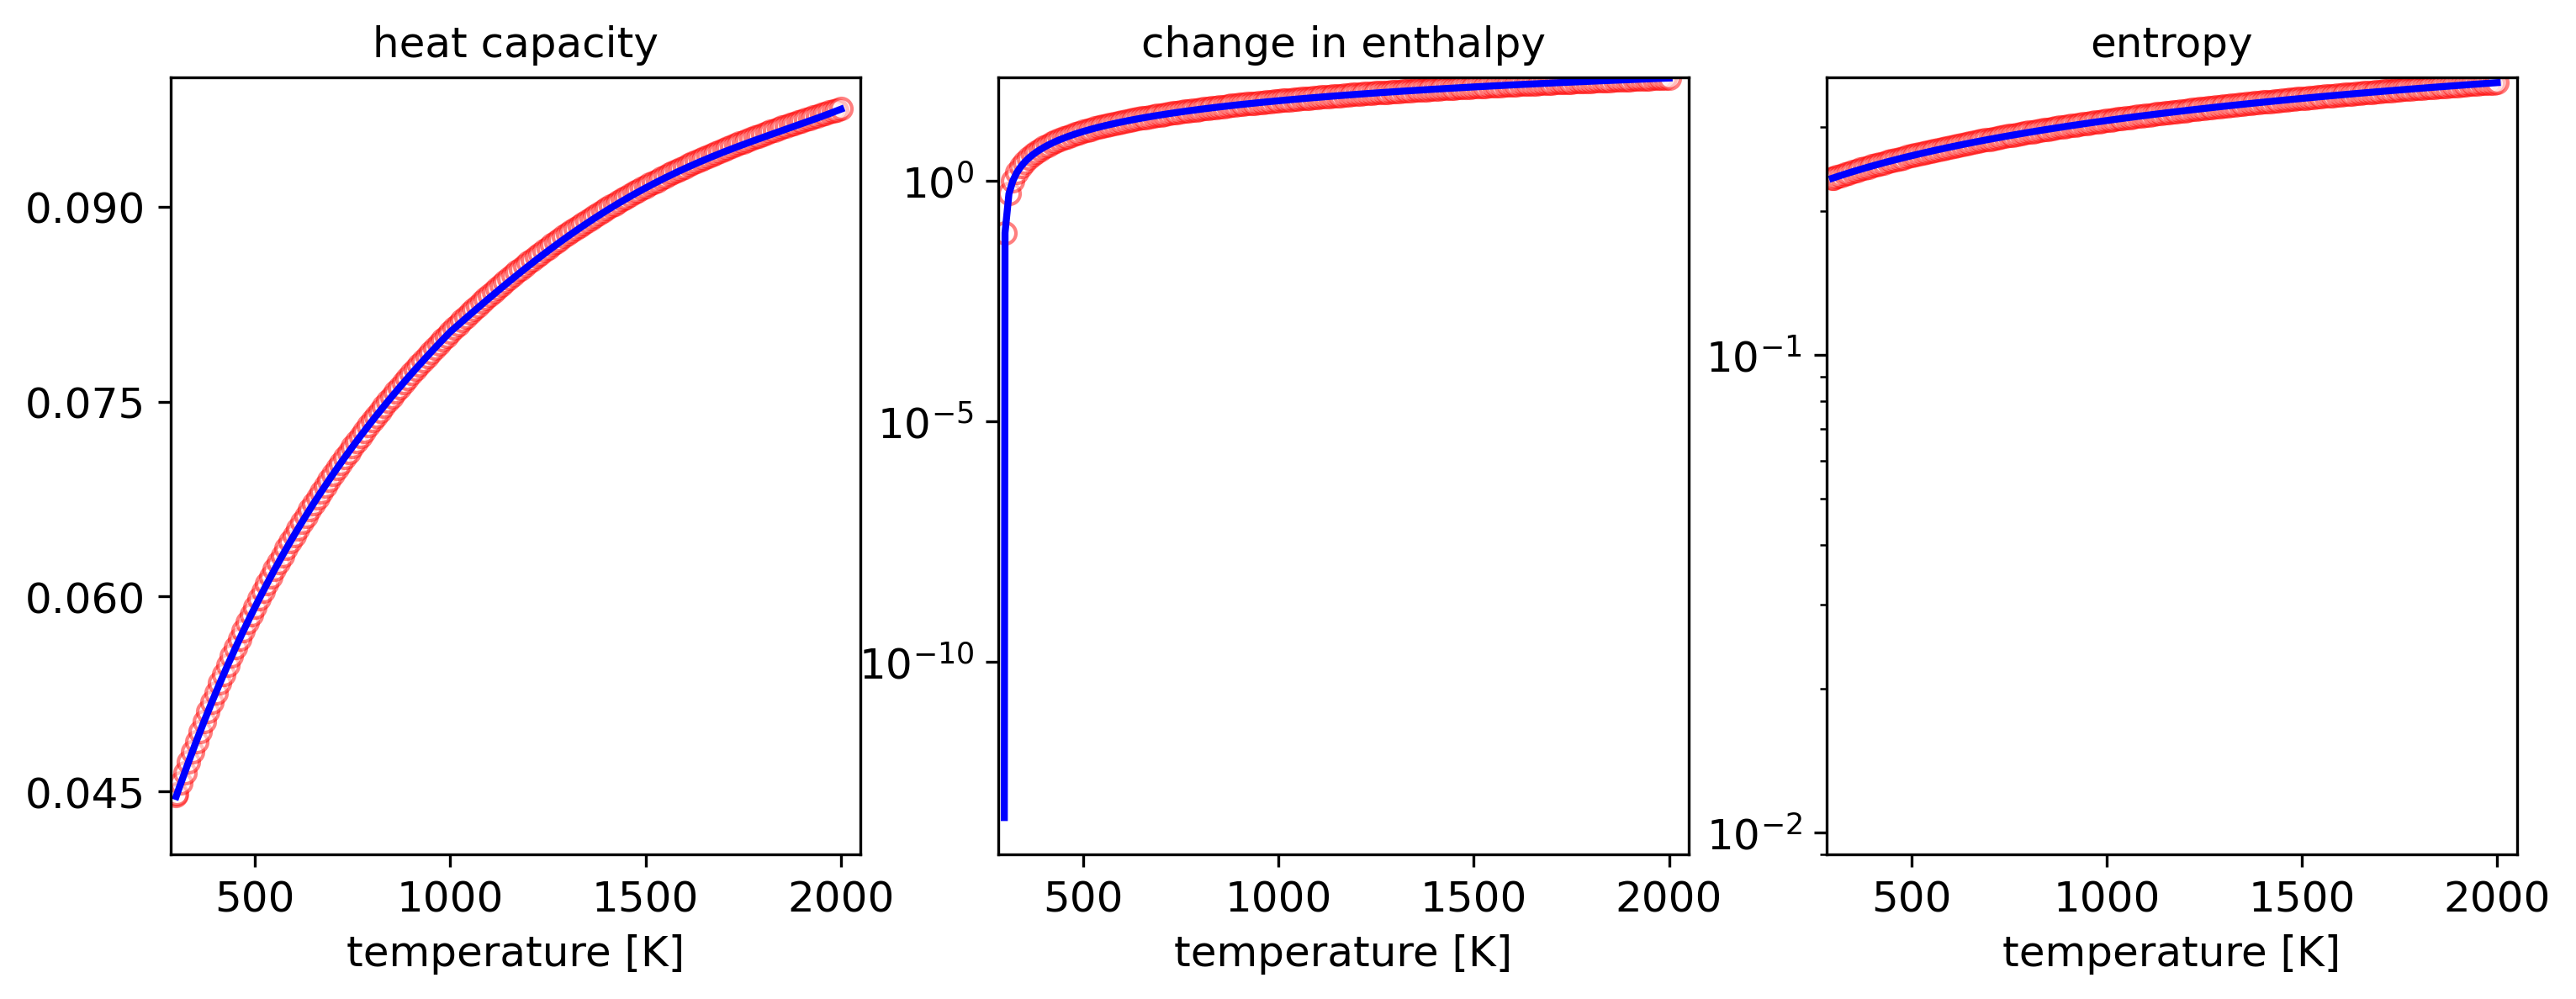

In [3]:
test = Molecule()
node = 'C-*R2' #varies
parse_input_file(node, 'CHCH2.dat',test)
thermo(test, temperature)
get_thermo_from_NASA(temperature, test)
compare_NASA_to_thermo(temperature, test)

C-*R2/CH2CCH3.dat
8
['77.95', ' 8.61', ' 8.14', ' GHZ']
GHZ
right rot units
successfully parsed file CH2CCH3.dat
Molecular mass= 41.07 g/mol
C-*R2/CH2COH.dat
6
['103.41', ' 10.06', ' 9.29', ' GHZ']
GHZ
right rot units
successfully parsed file CH2COH.dat
Molecular mass= 43.04 g/mol
C-*R2/CH3CO.dat
6
['81.56', ' 9.97', ' 9.42', ' GHZ']
GHZ
right rot units
successfully parsed file CH3CO.dat
Molecular mass= 43.04 g/mol
C-*R2/CHCCH2.dat
6
['291.1', ' 9.57', ' 9.27', ' GHZ']
GHZ
right rot units
successfully parsed file CHCCH2.dat
Molecular mass= 39.06 g/mol
C-*R2/CHCH2-mono.dat
5
['243.33', ' 32.59', ' 28.74', ' GHZ']
GHZ
right rot units
successfully parsed file CHCH2-mono.dat
Molecular mass= 27.05 g/mol
C-*R2/CHCHCH3-mono.dat
8
['58.7', ' 9.38', ' 8.52', ' GHZ']
GHZ
right rot units
successfully parsed file CHCHCH3-mono.dat
Molecular mass= 41.07 g/mol
C-*R2/CHCO-mono.dat
4
['10.67', ' GHZ']
GHZ
right rot units
successfully parsed file CHCO-mono.dat
Molecular mass= 41.03 g/mol
C-*R2/COOH.dat


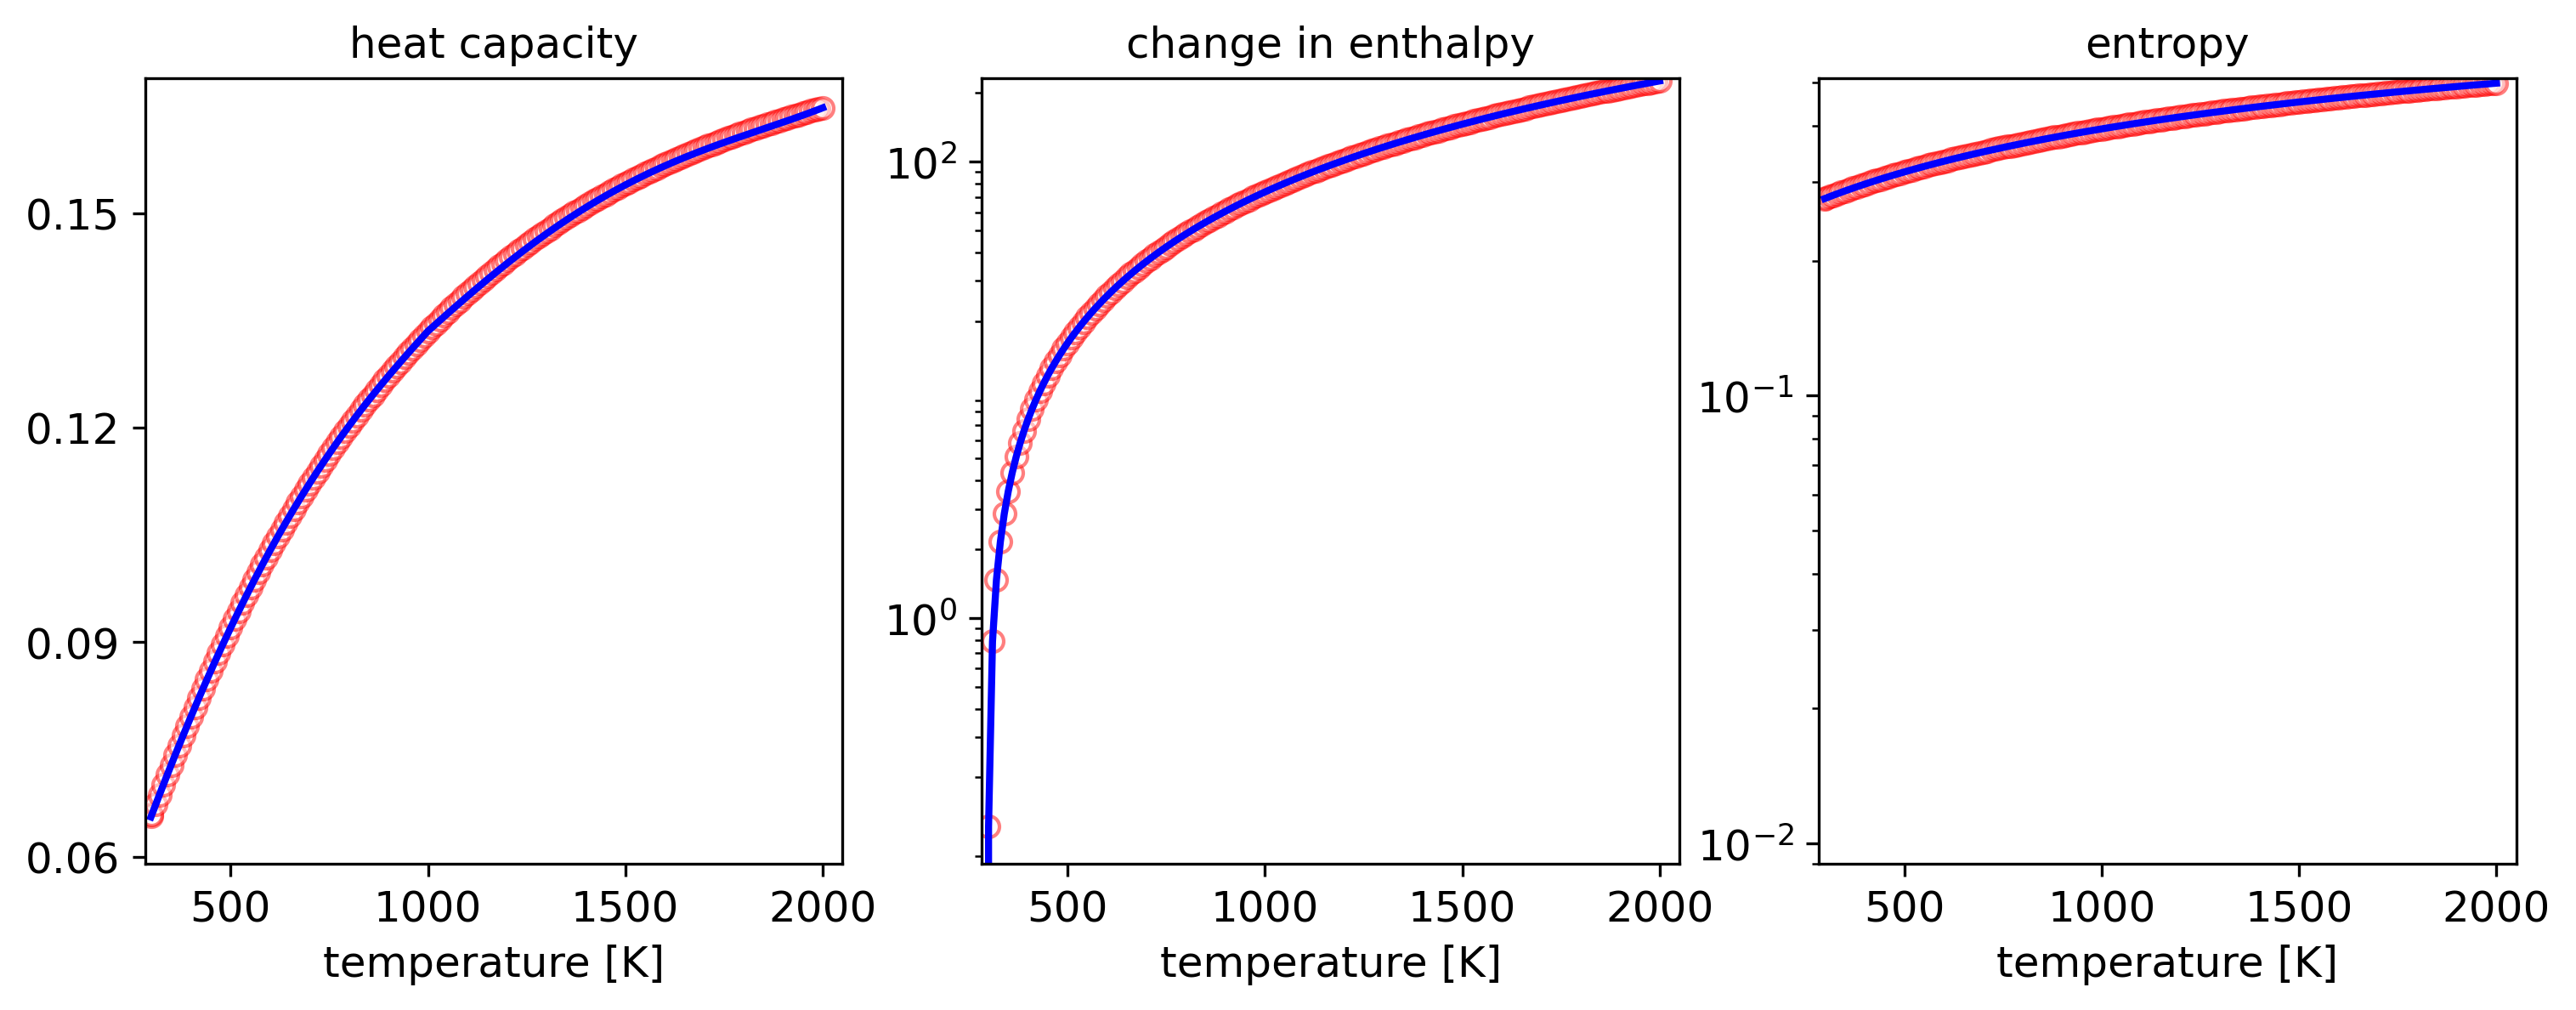

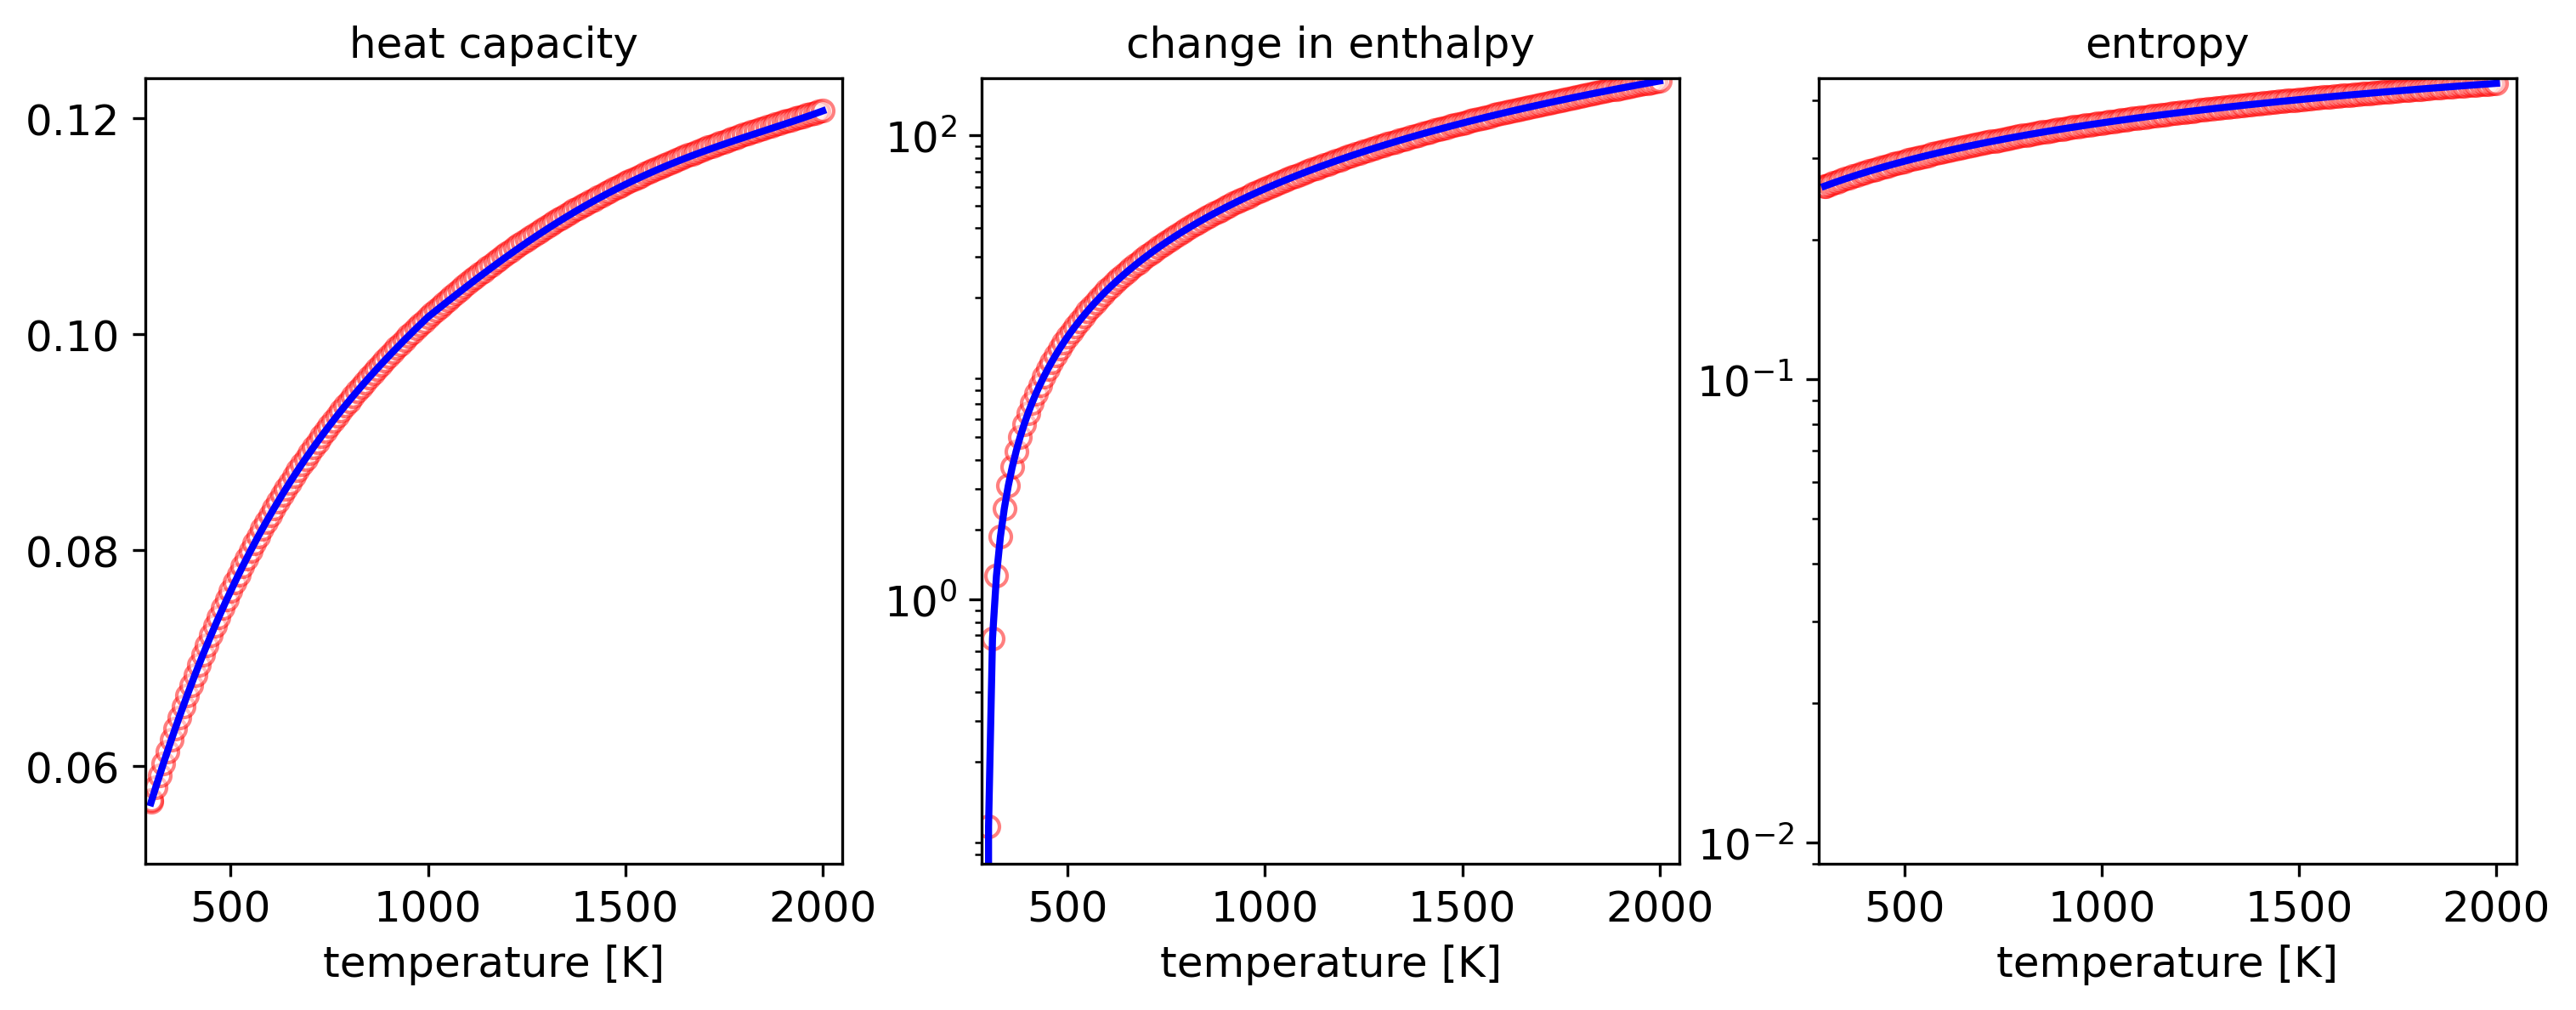

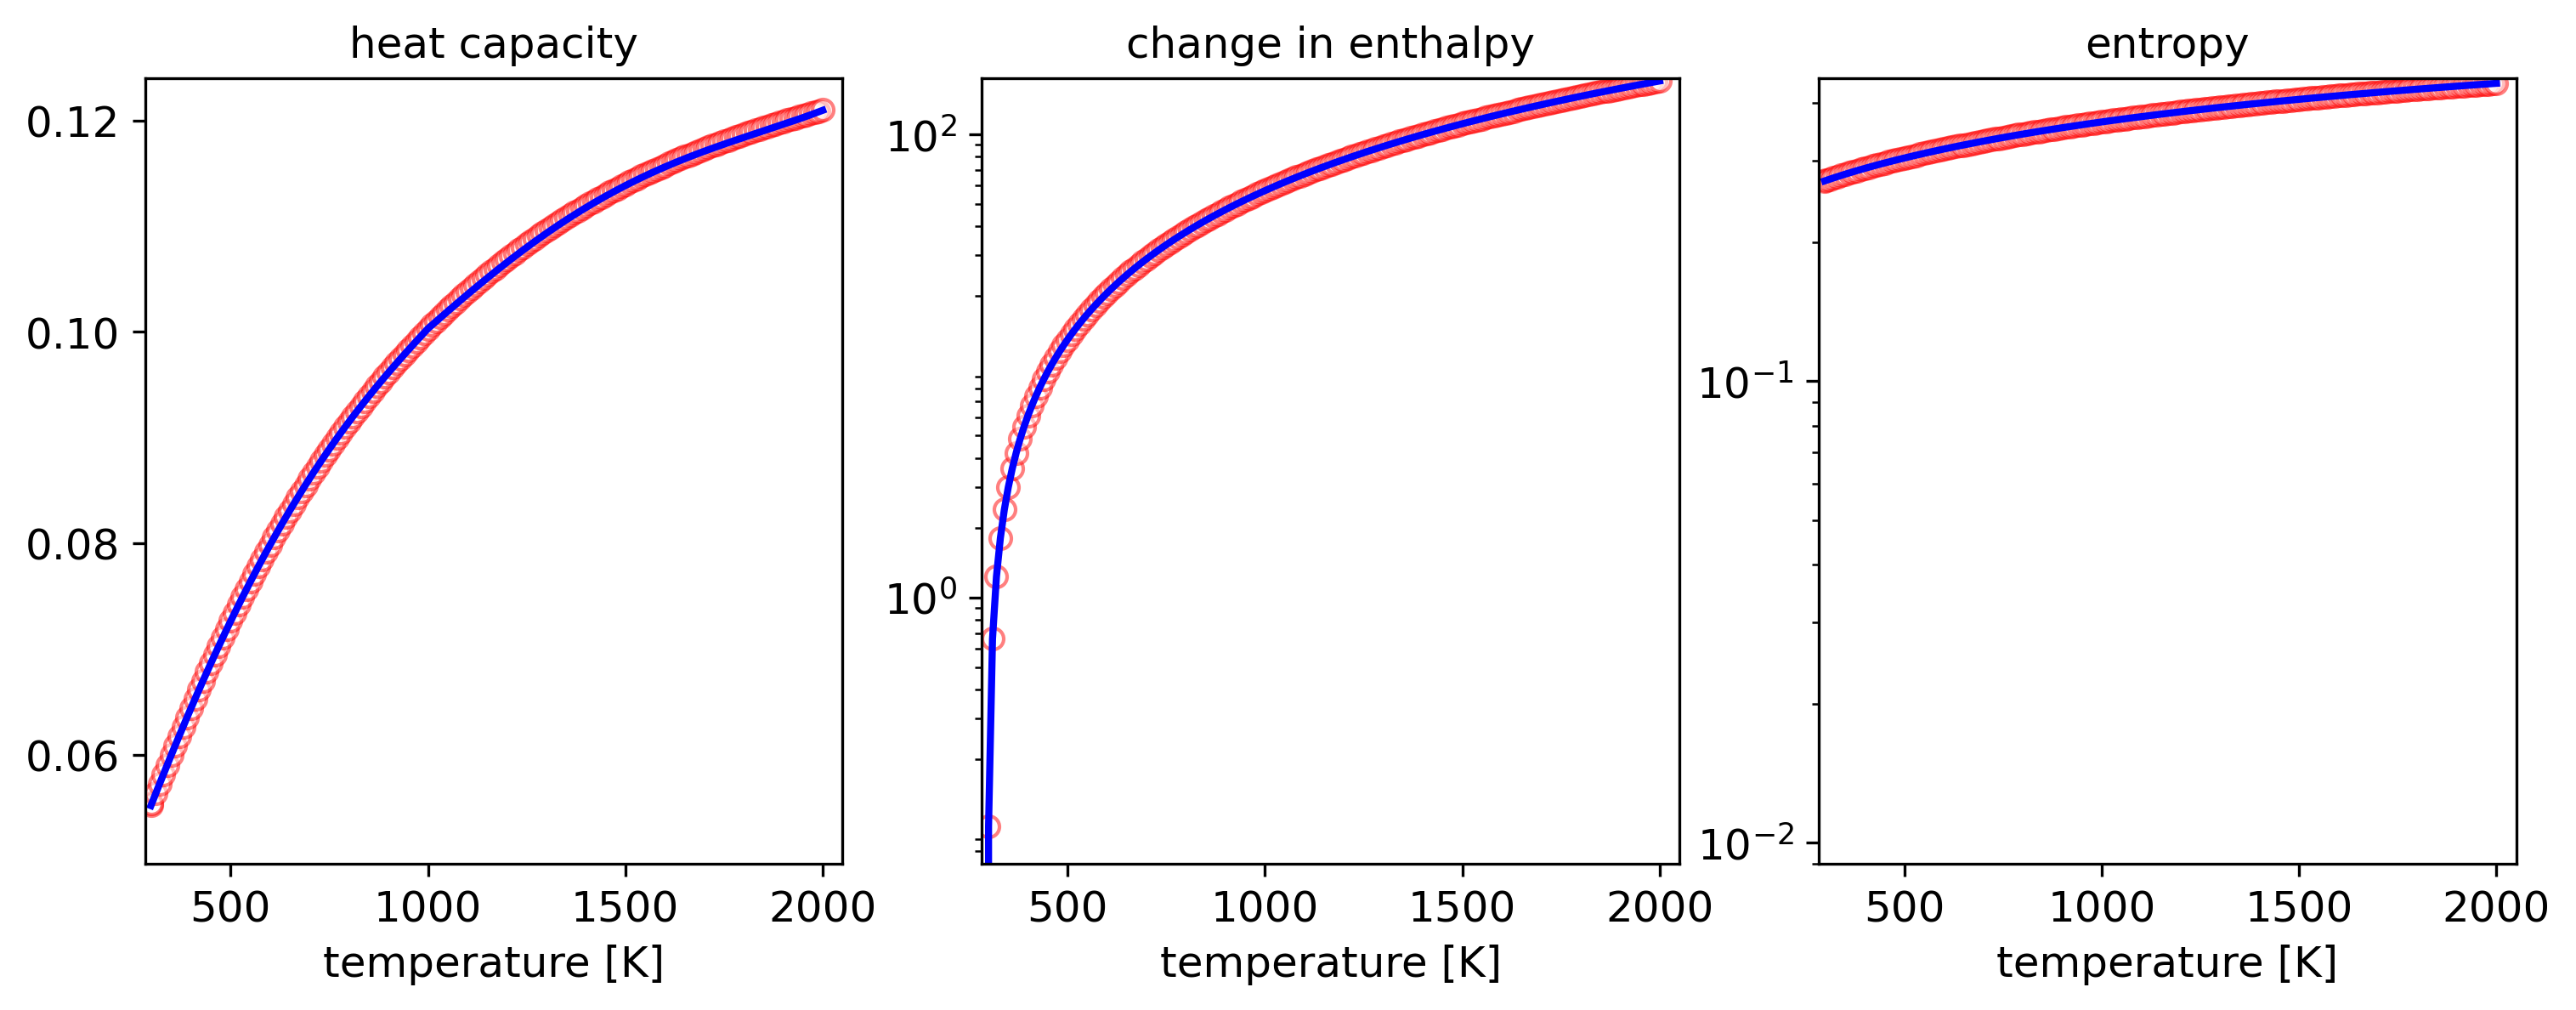

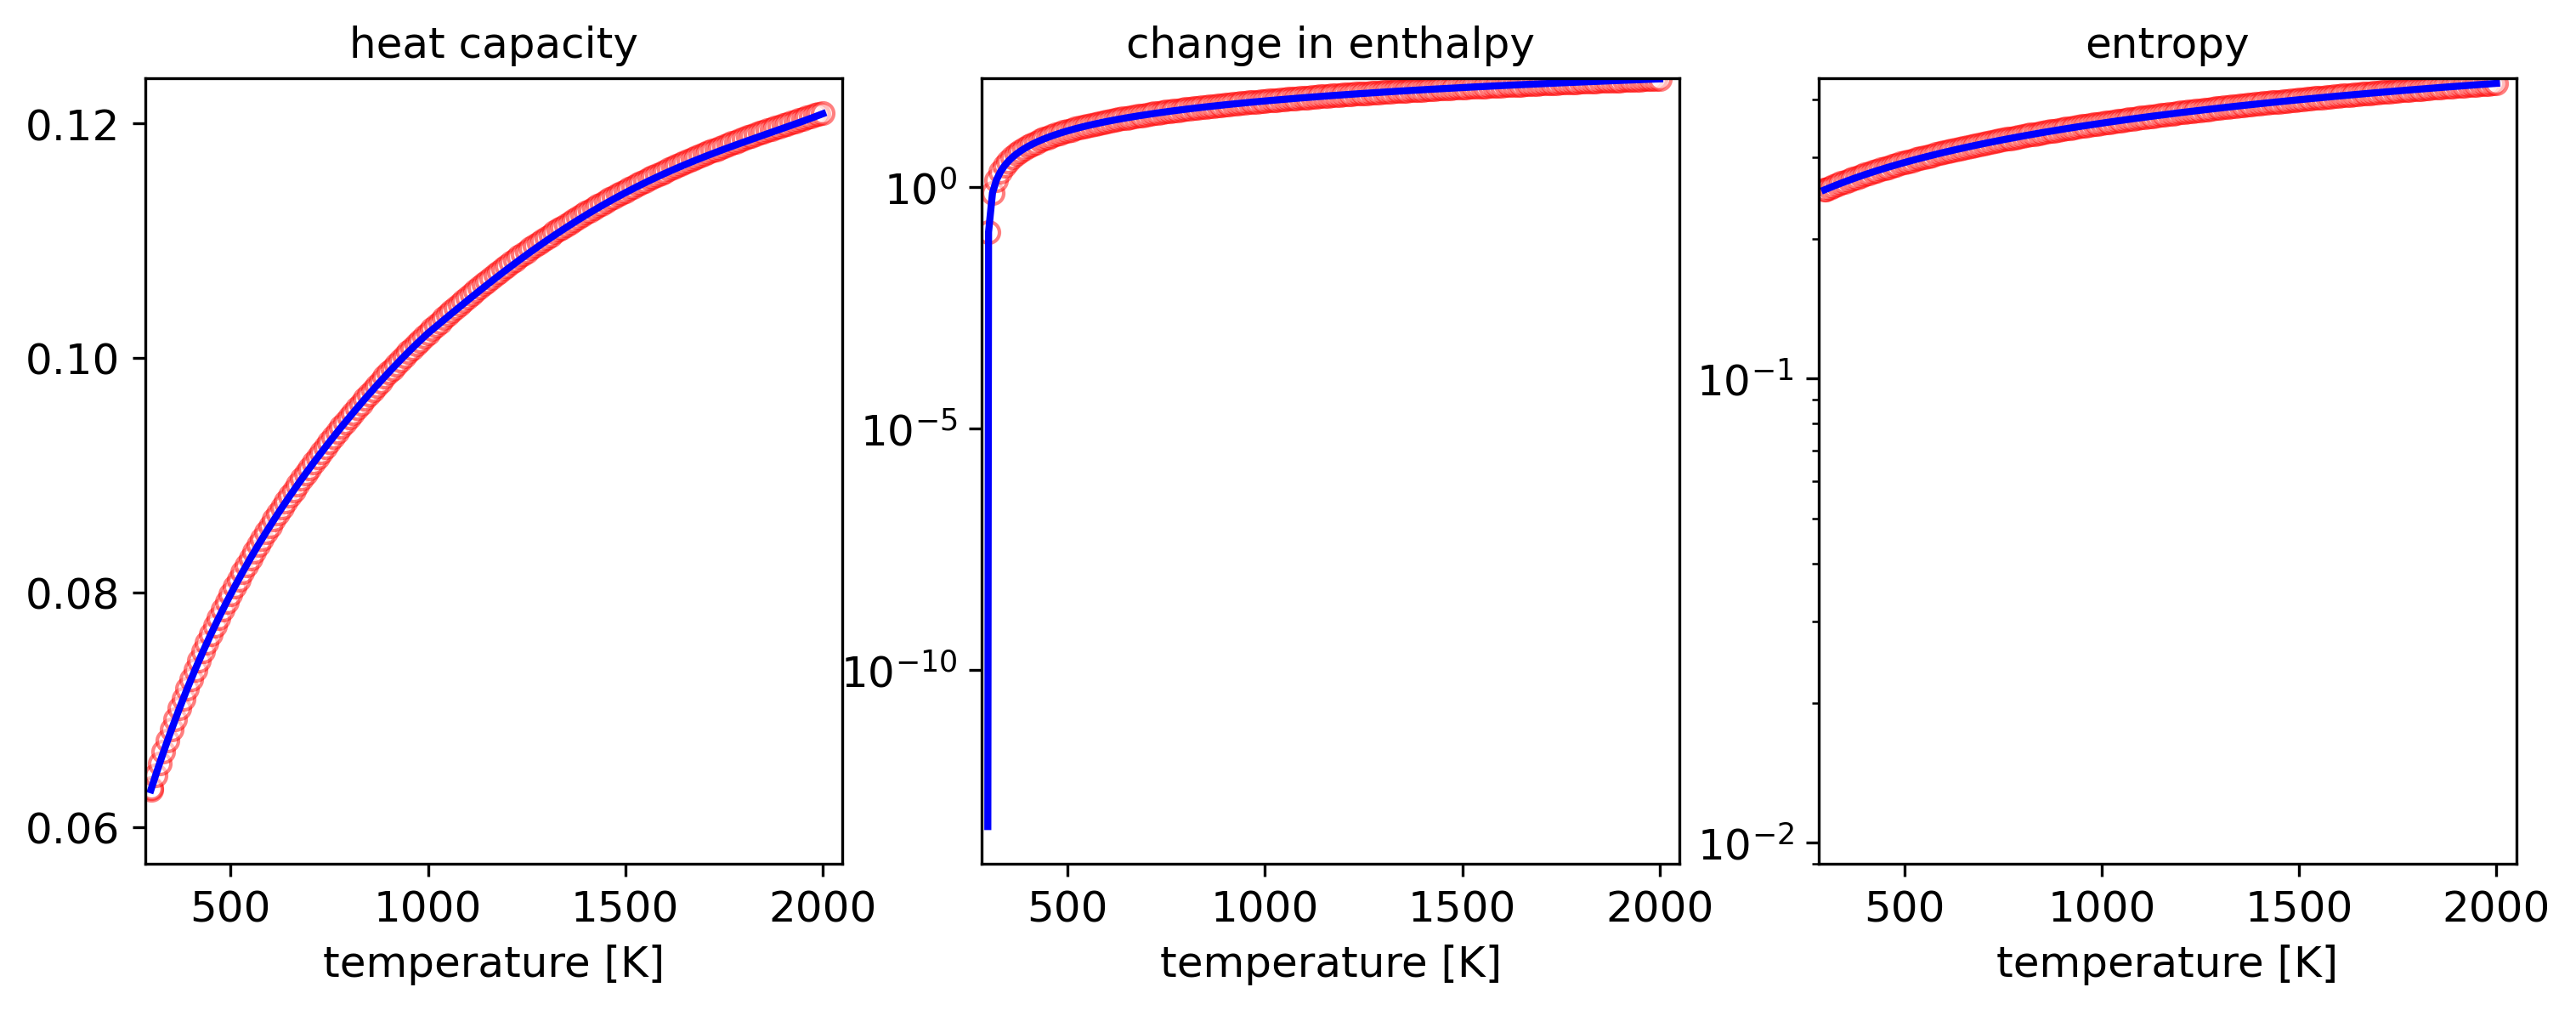

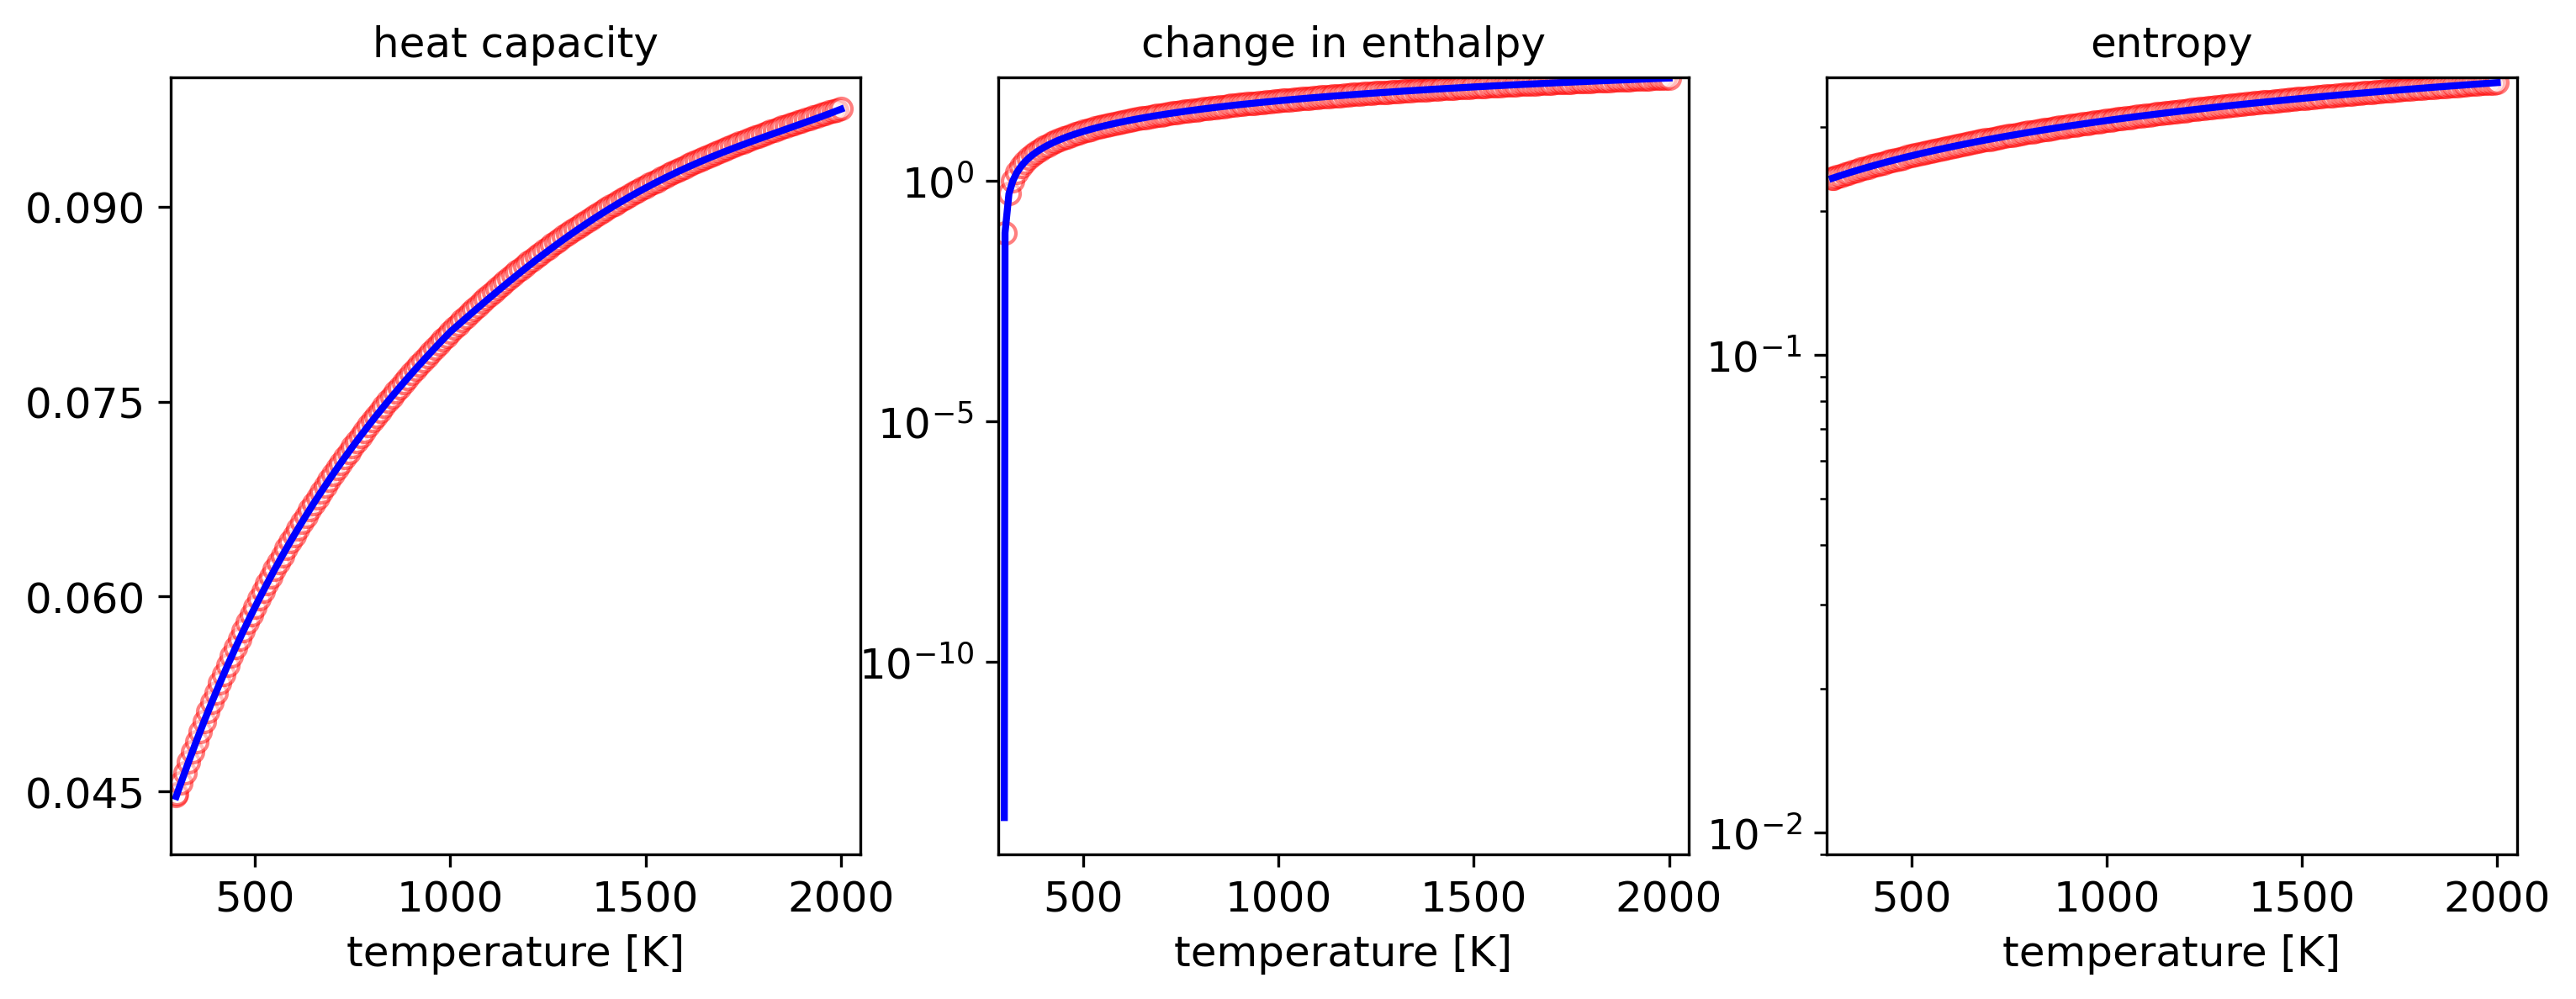

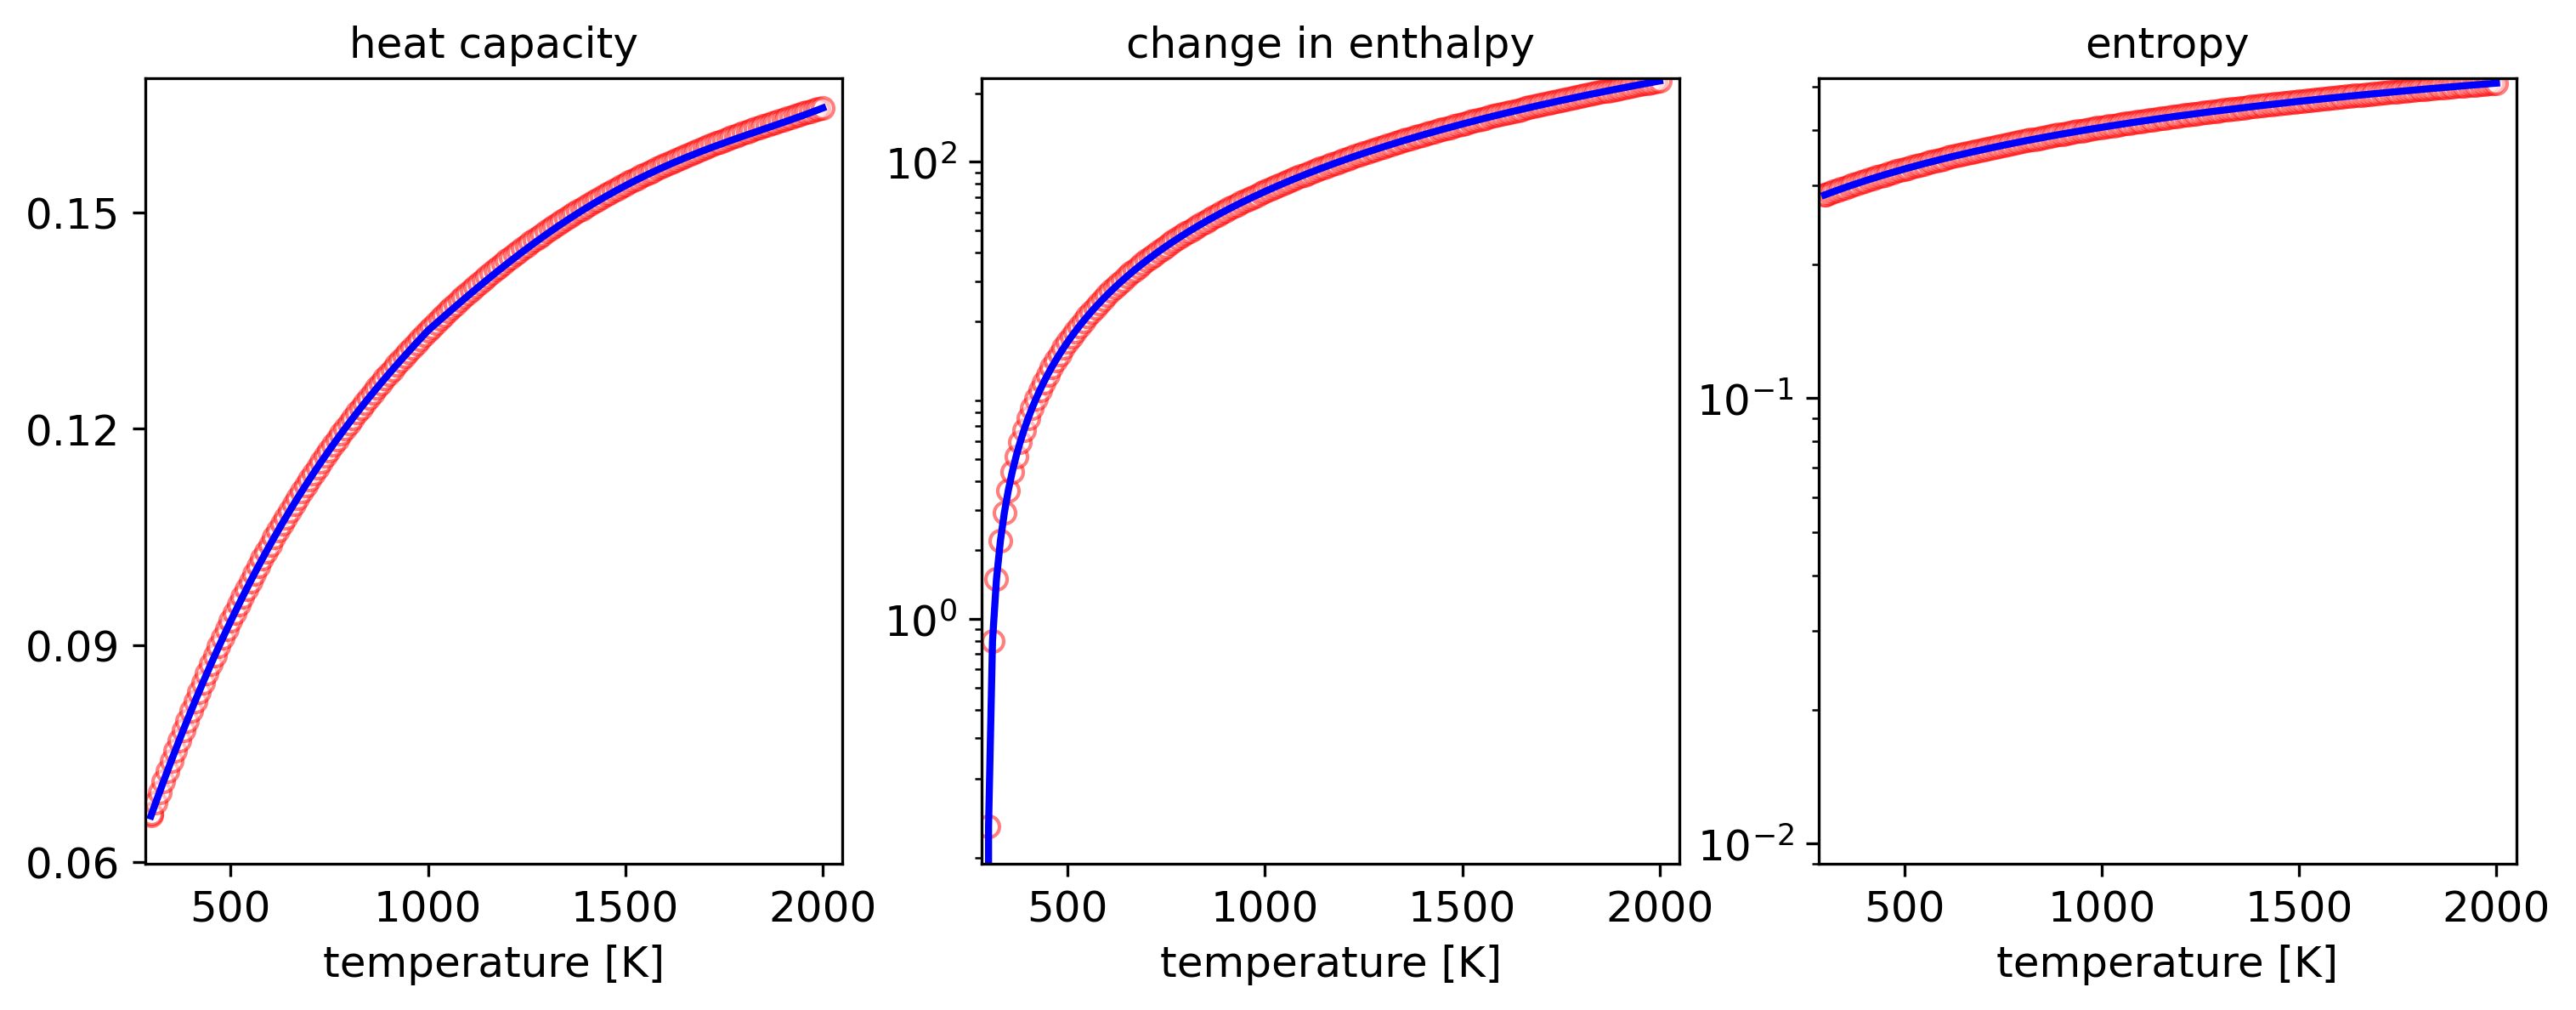

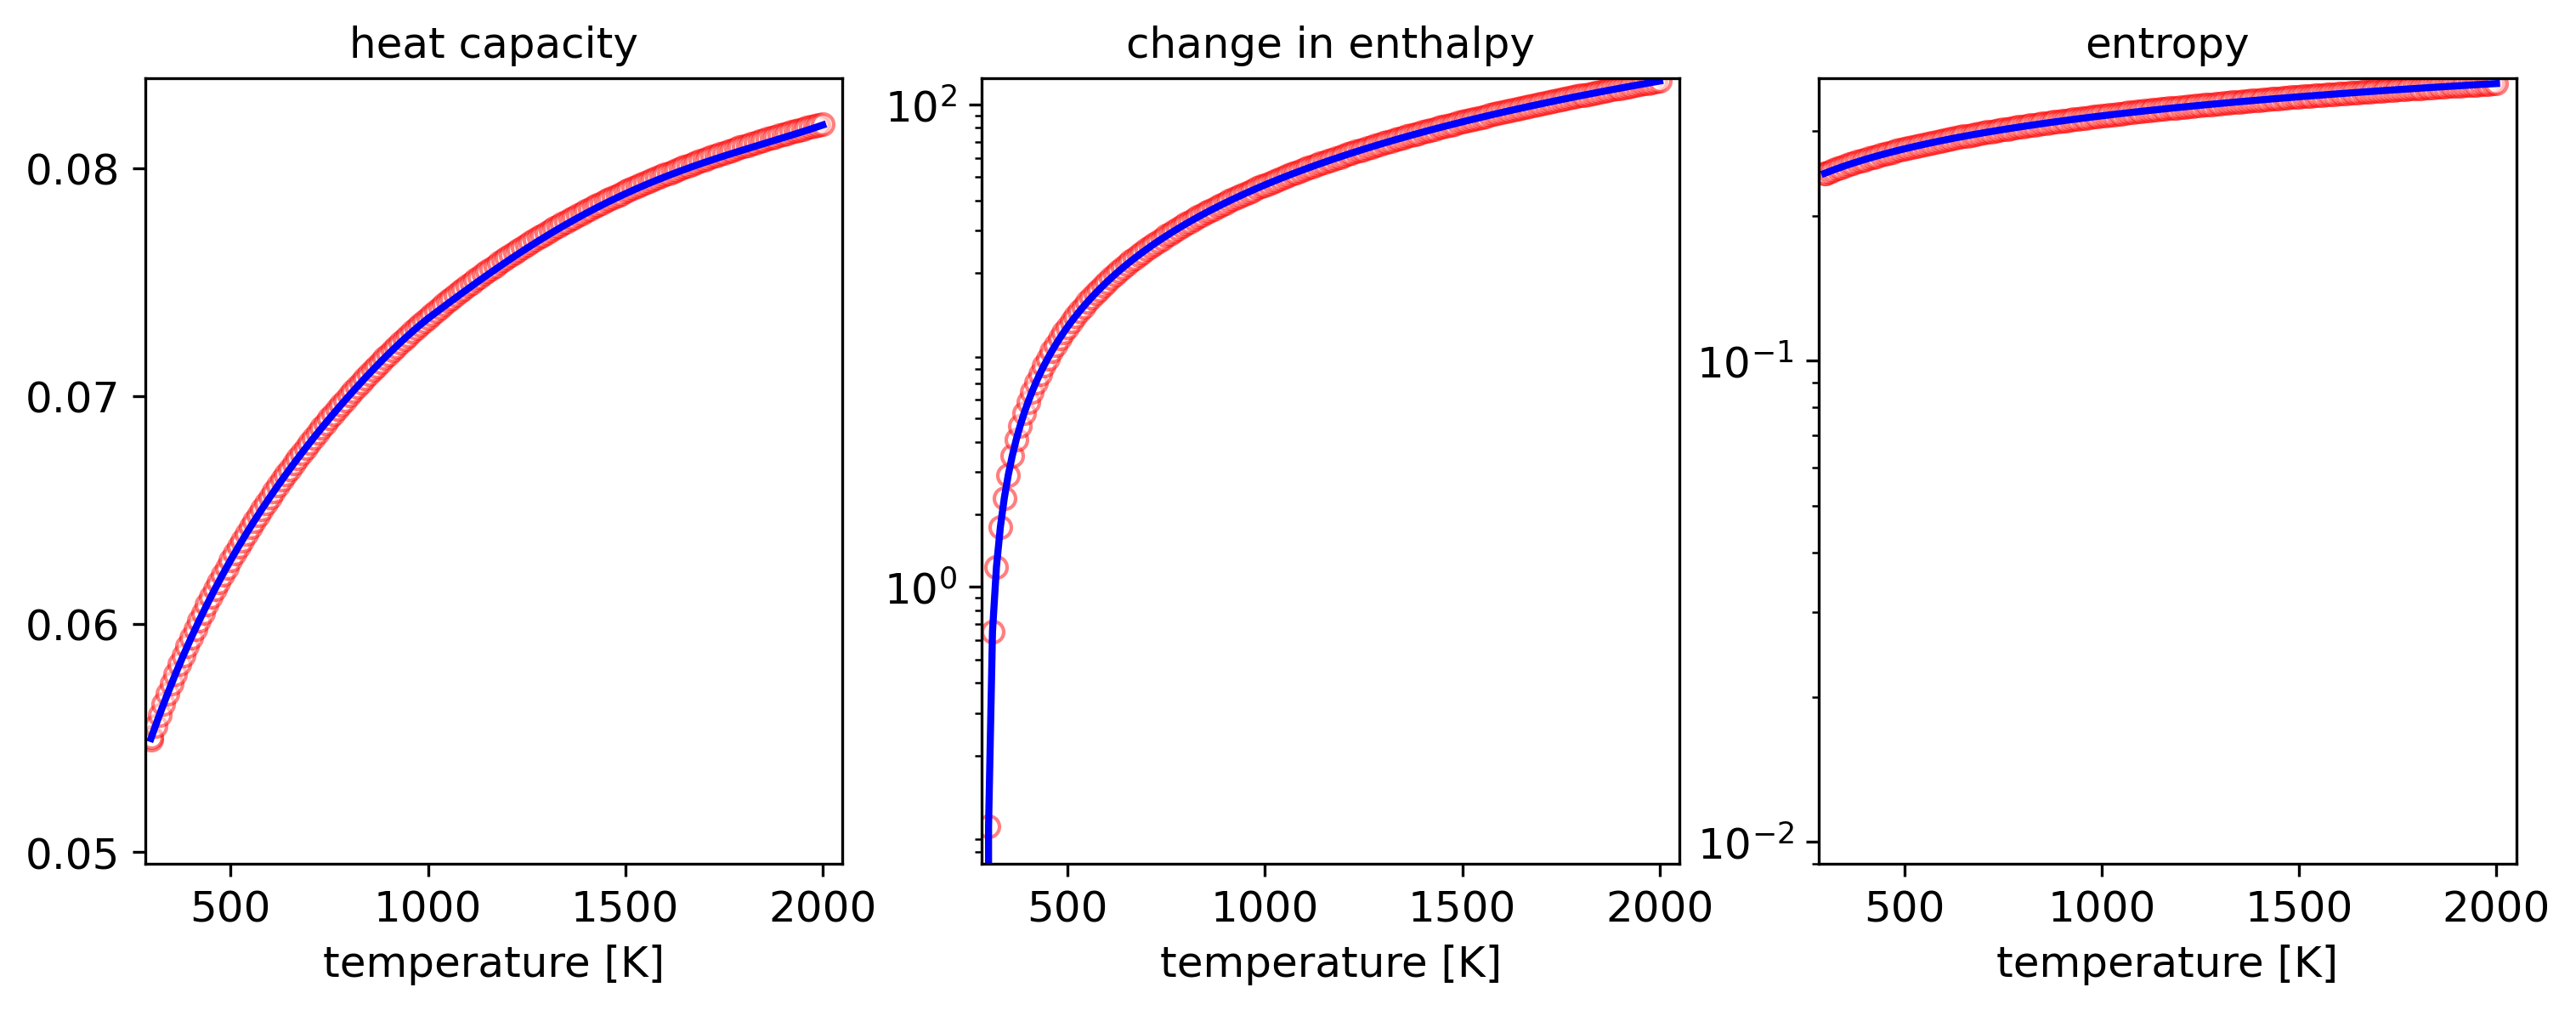

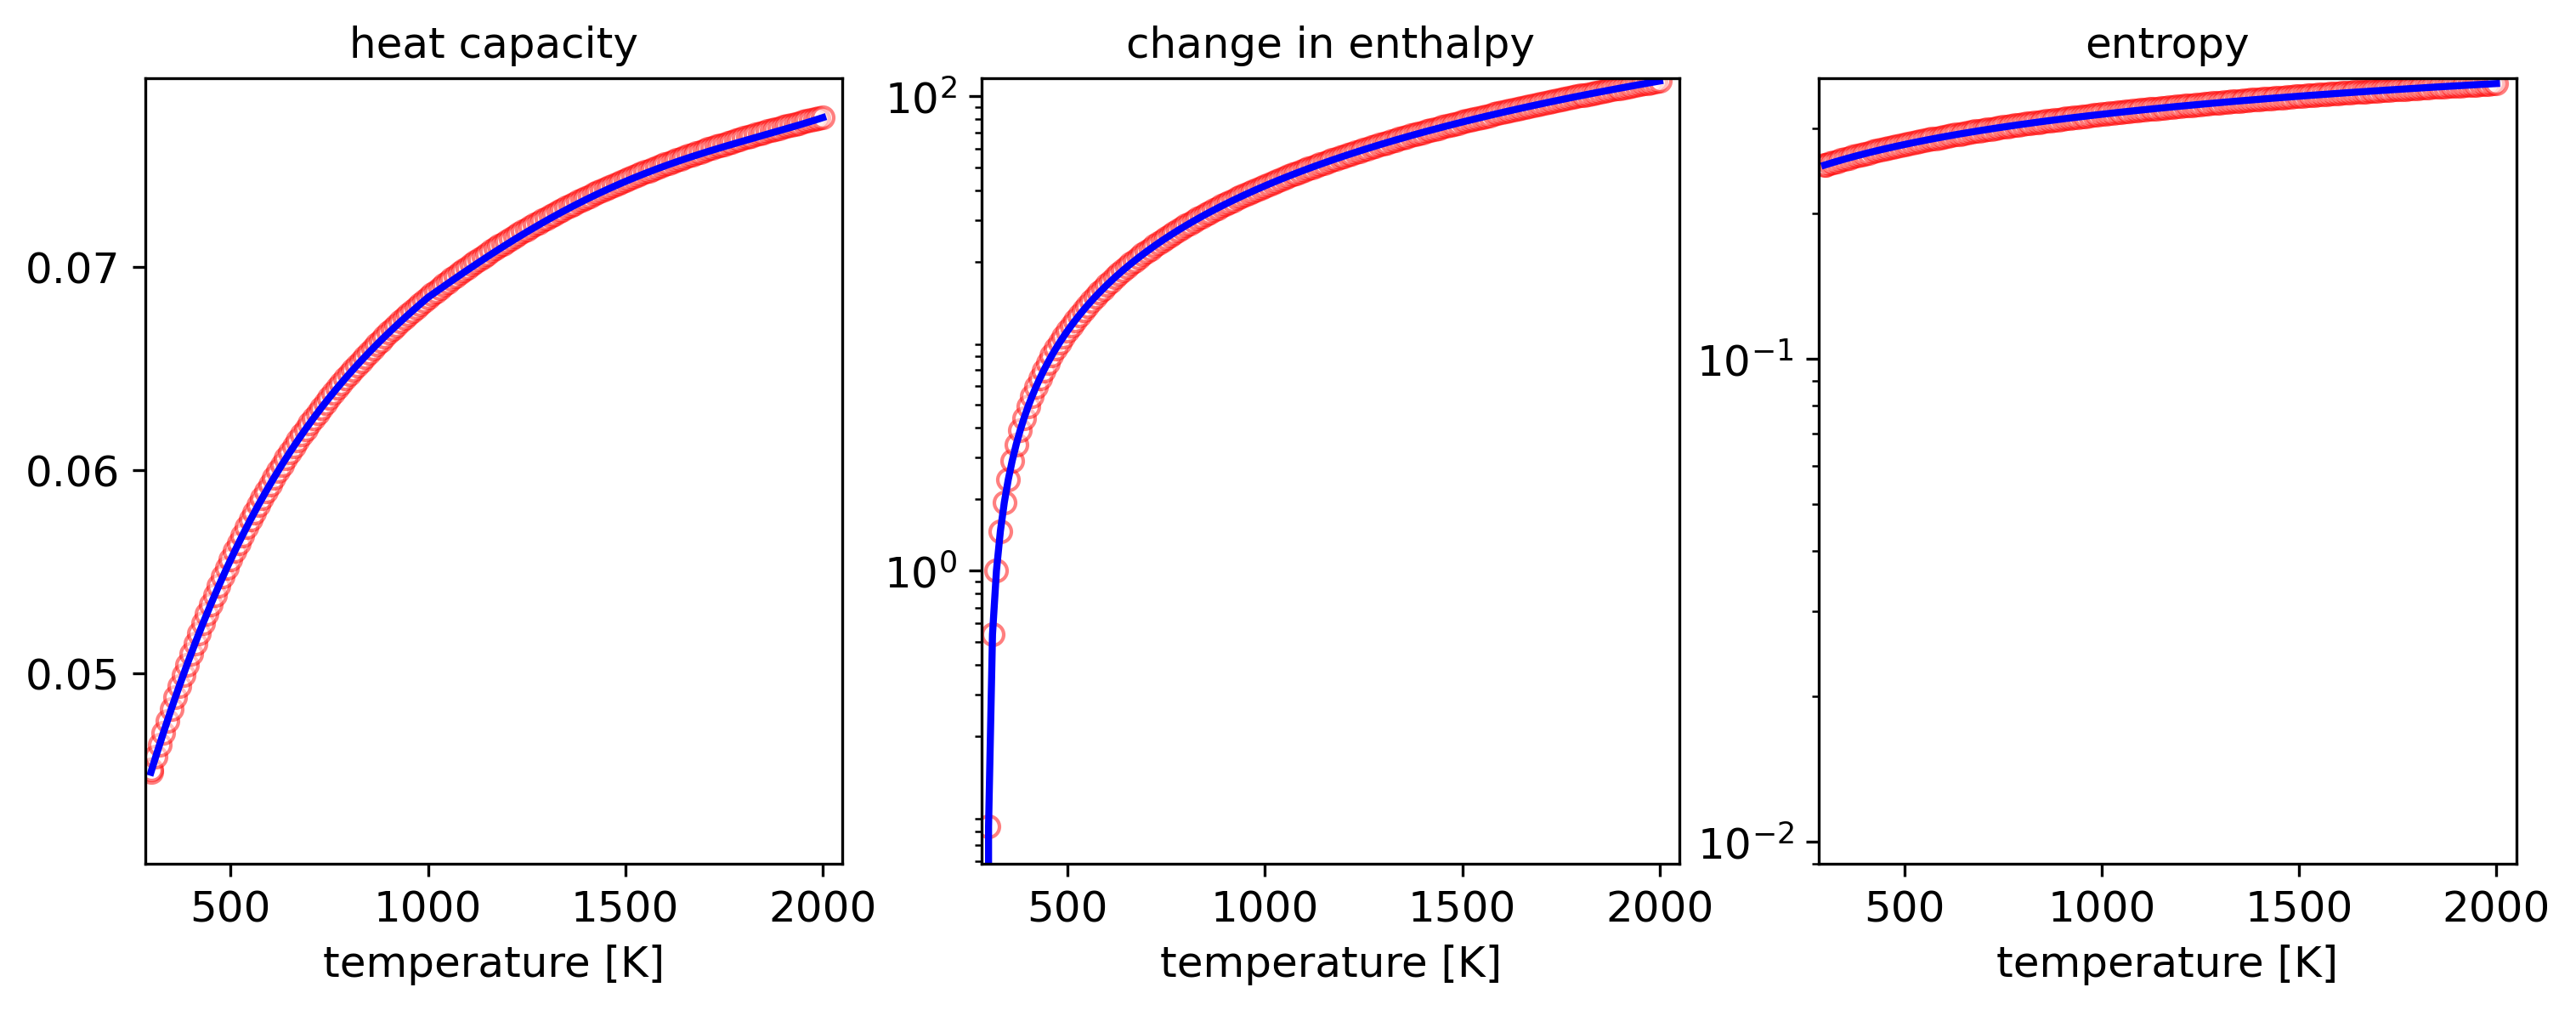

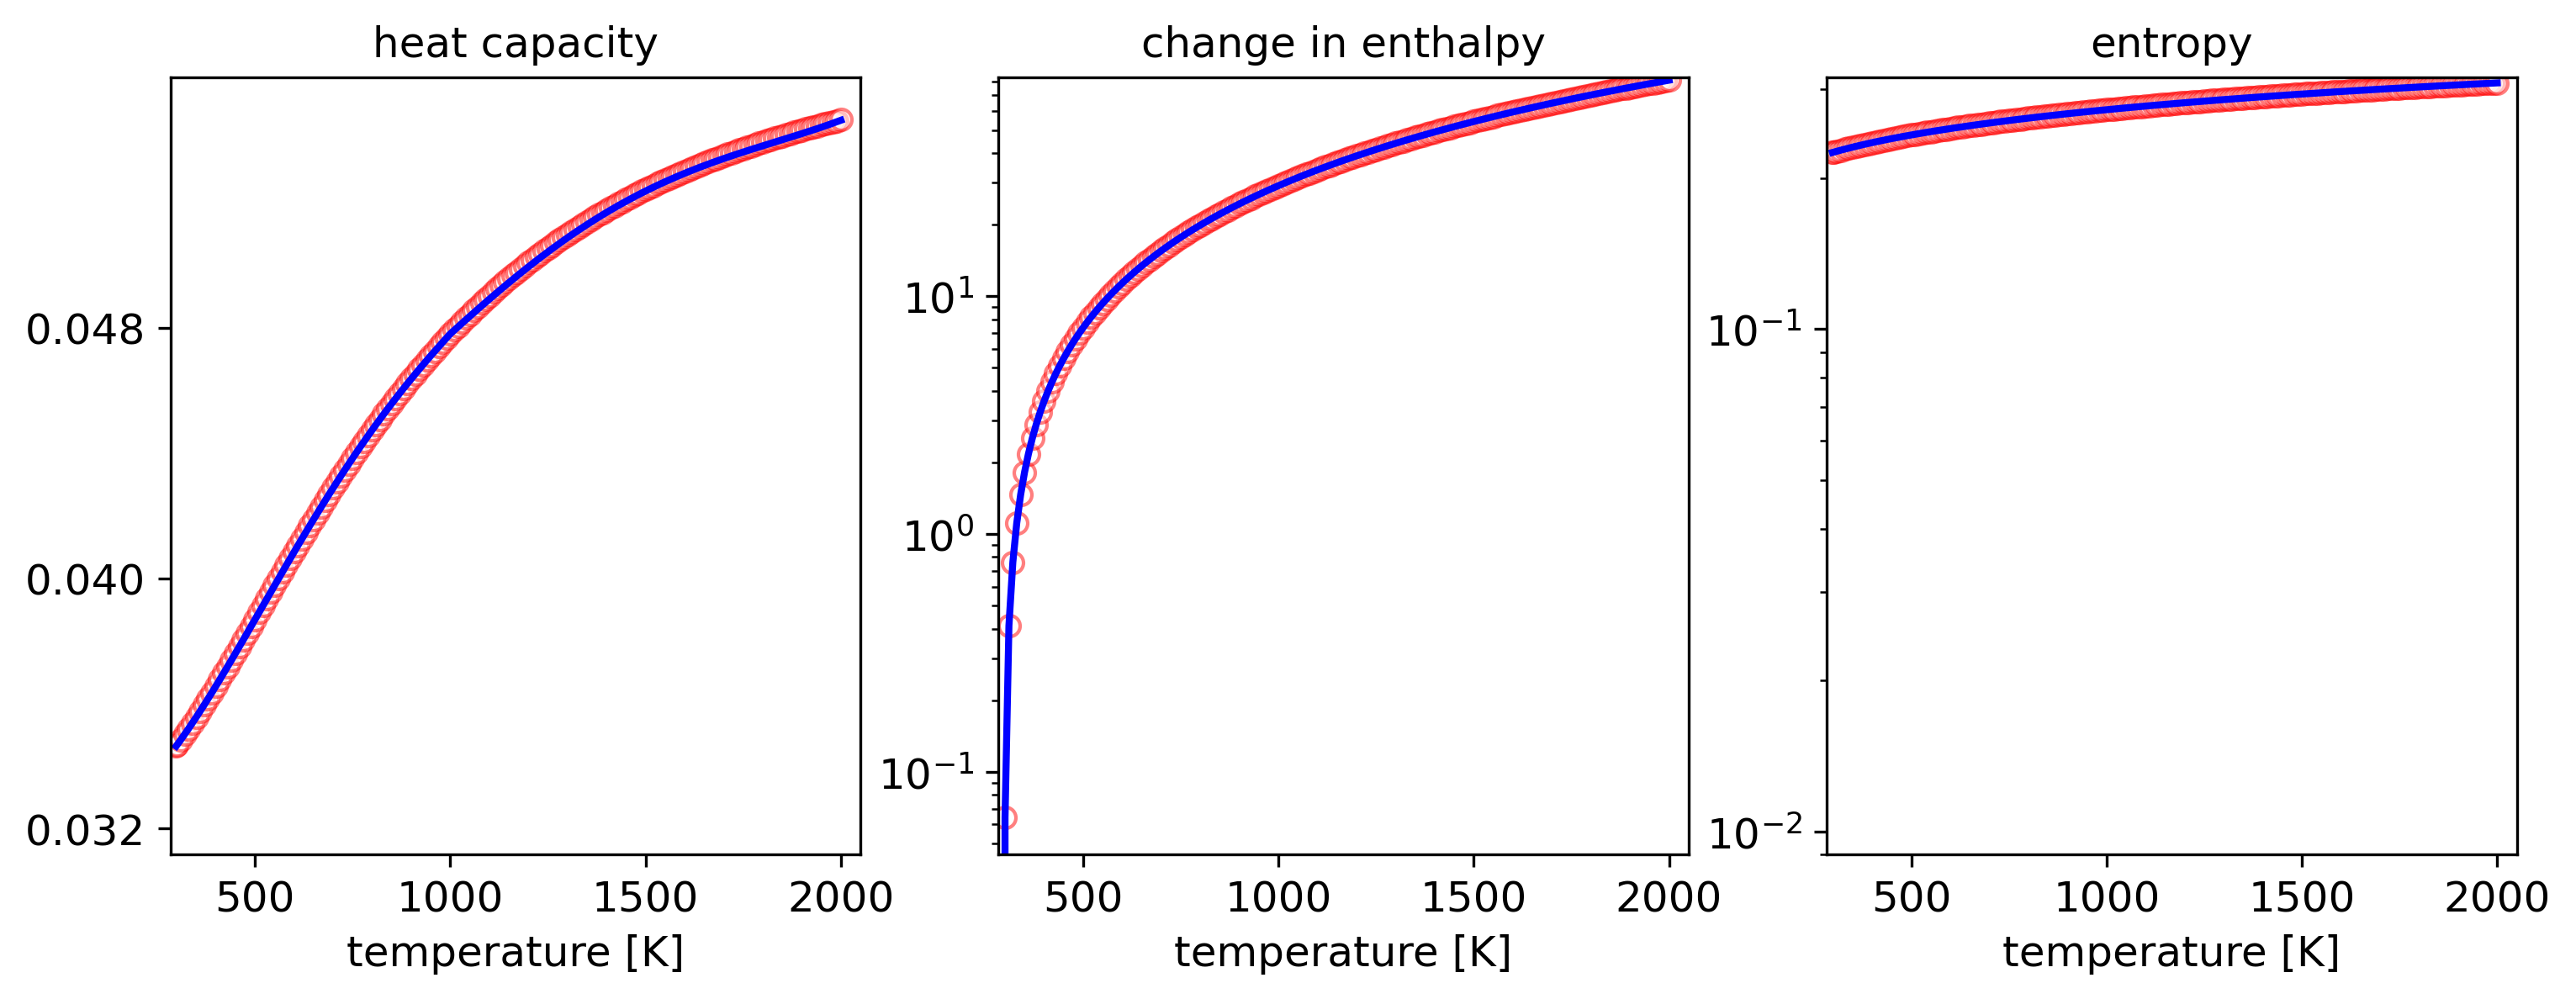

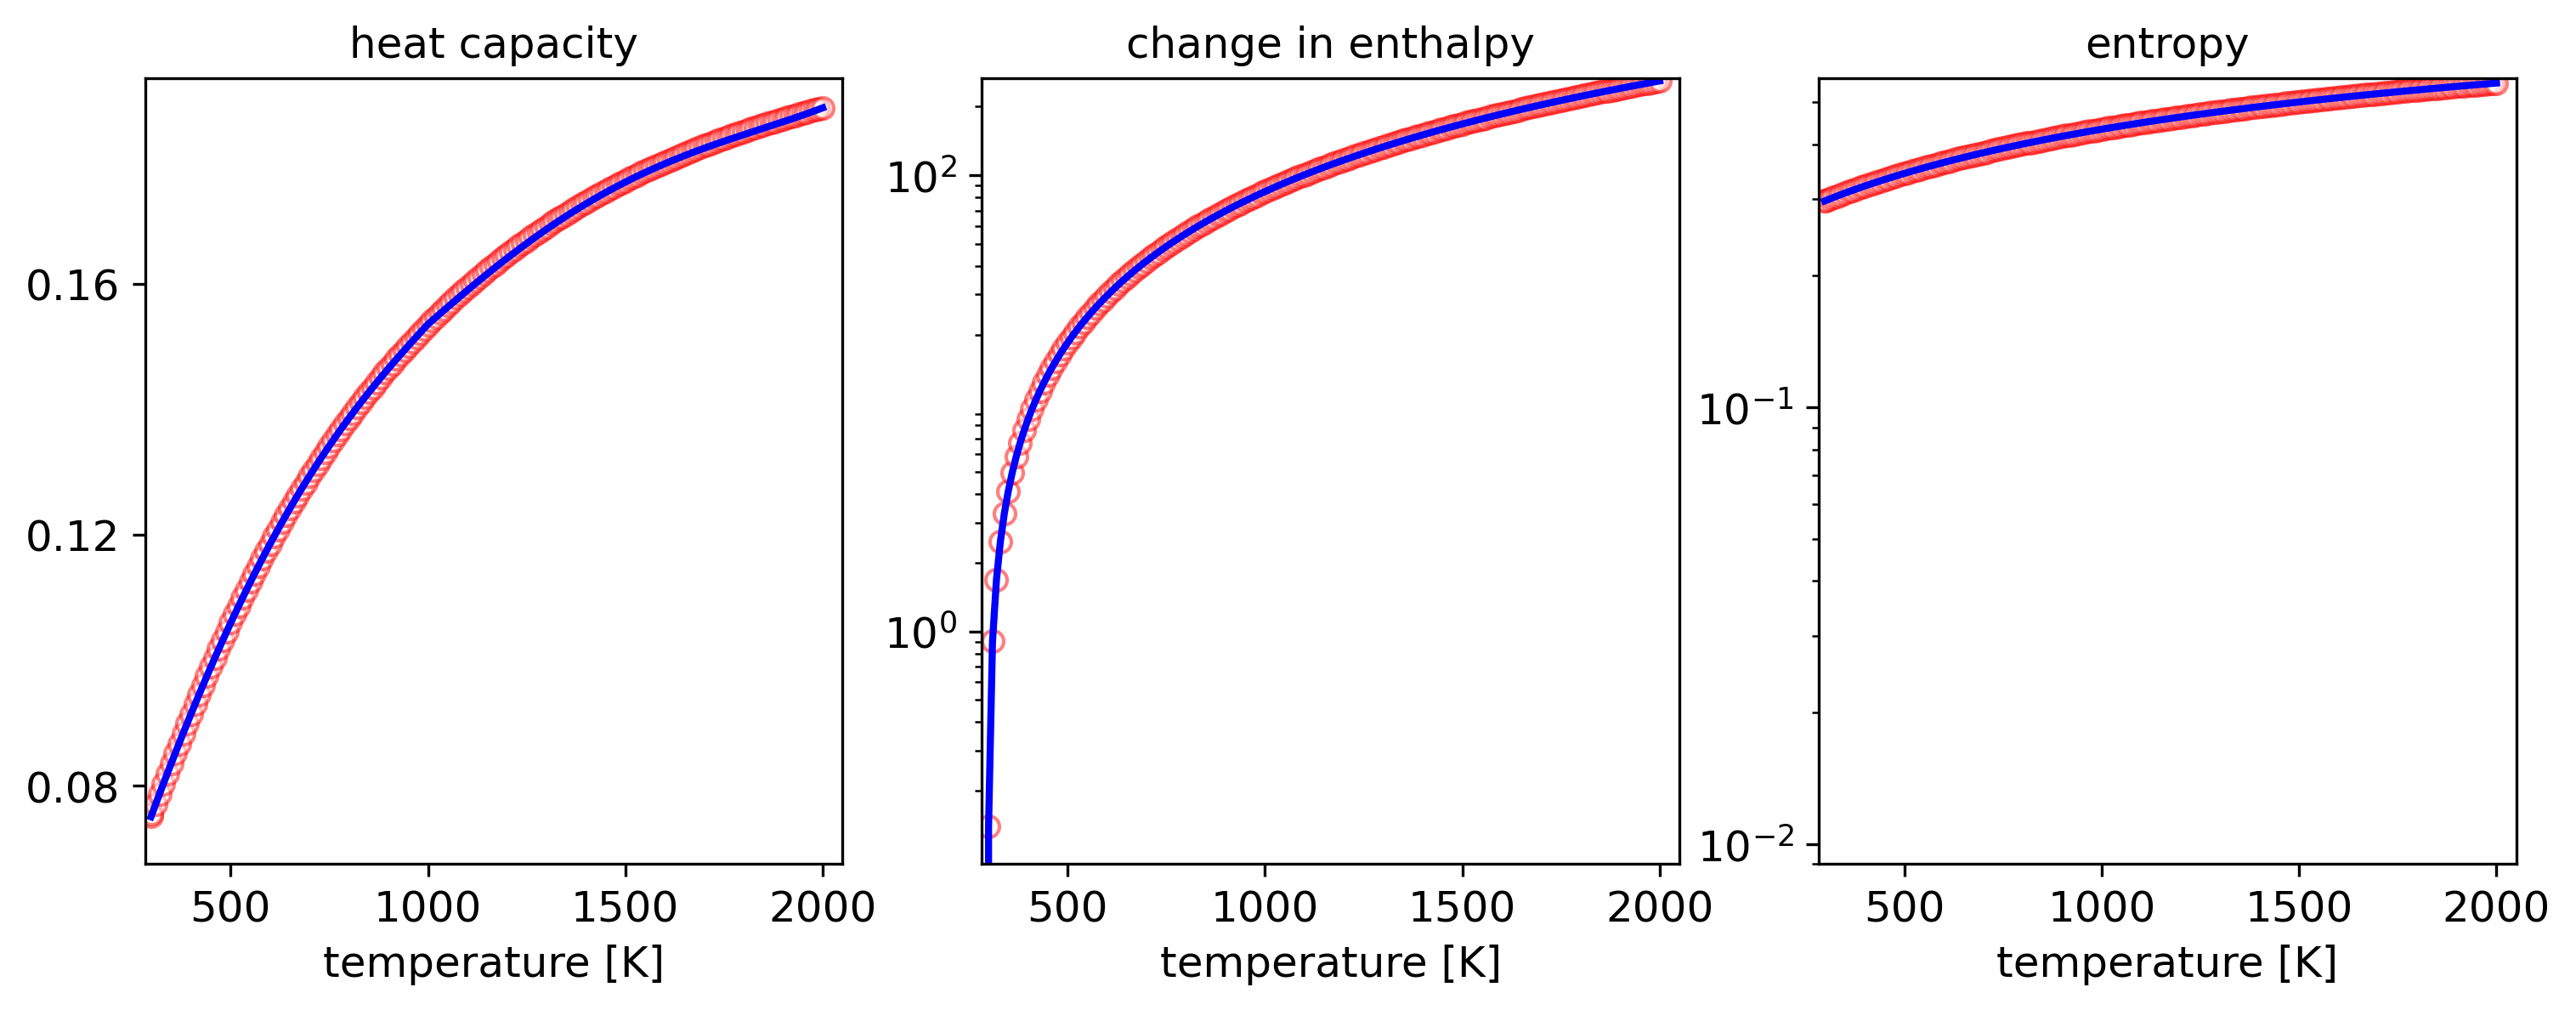

In [6]:
node='C-*R2'
list_of_species = str(node) + '/species_list_' + str(node) + '.dat'
info = open(list_of_species,'r')
species_list = info.readlines()
info.close()

new_output = open('my_new_cti_gas.txt', 'w')

name_line = '\n'
species_line = '\n'

counter = -1
for species in species_list:
    counter += 1
    filename = species.strip()
    test = Molecule()
    parse_input_file(node, filename, test)
    thermo(test, temperature)
    
    name_line += ' %s'%(test.name)
    if counter == 4:
        name_line +='\n'
        counter == -1
    species_line += test.species_lines
    
    get_thermo_from_NASA(temperature, test)
    compare_NASA_to_thermo(temperature, test)

name_line += '\n\n' 
new_output.write(name_line)
new_output.write(species_line)

new_output.close()